In [1]:
suppressPackageStartupMessages({
    ## This is my custom library for various helper functions for spatial pre-processing 
    # devtools::install_github('korsunskylab/spatula', dependencies = FALSE)    
    # devtools::install_github('korsunskylab/spatula')
    library(harmony)
    library(uwot)
    library(singlecellmethods)
    library(sfarrow)
    library(geojsonsf)
    library(sf)    
    library(spatula)
    library(purrr)
    library(furrr)
    library(circlize)
    library(ComplexHeatmap)
    library(ggrepel)
    library(future)
    library(scales)
    library(glue)
    library(data.table)
    library(spatstat)
    library(tidyr)
    library(dplyr)
    library(data.table)
    library(presto)
    library(ggplot2)
    library(ggthemes)
    library(patchwork)
    library(Matrix)
})

fig.size <- function(h, w) {
    options(repr.plot.height = h, repr.plot.width = w)
}

## Clustering functions 
# source('../ModularityClustering/R/modularity_clustering.R')
# sourceCpp('../ModularityClustering/src/RModularityOptimizer.cpp')


source('utils_plotting.R')
source('utils.R')


readMM_fast <- function(fname, max_header_size = 100, nthreads = NULL) {
    ## First, figure out how many lines to skip
    ## Assumes that MM format has comments that start with %
    nlines_skip <- 0
    con <- file(fname, open = 'r')
    for (i in seq_len(max_header_size)) {
        line <- readLines(con, 1)
        nlines_skip <- nlines_skip + 1
        if (!grepl('^\\W*\\%', line)) {
            ## This is the line with dimension information 
            ## We need dimension information to handle empty rows and columns 
            nrow <- as.integer(strsplit(line, ' ')[[1]][1])
            ncol <- as.integer(strsplit(line, ' ')[[1]][2])
            break
        }
    }
    close(con)

    if (is.null(nthreads)) {
        nthreads <- data.table::getDTthreads()
    }
    ## Then, read the file and make a matrix 
    with(
        fread(fname, skip = nlines_skip, nThread = nthreads),
        Matrix::sparseMatrix(i = V1, j = V2, x = V3, dims = c(nrow, ncol))
    )
}


writeMM_fast <- function(X, fname) {
    stopifnot(is(X, 'dgCMatrix'))
    nelem <- length(X@i)
    nrow <- X@Dim[1]
    ncol <- X@Dim[2]    
    writeLines(paste0(c('%%MatrixMarket matrix coordinate real general\n', nrow, ' ', ncol, ' ', nelem), collapse = ''), fname)    
    fwrite(data.table(X@i+1, rep(seq_len(ncol), times = diff(X@p)), X@x), fname, append = TRUE, sep = ' ')        
}


Registered S3 methods overwritten by 'RcppEigen':
  method               from         
  predict.fastLm       RcppArmadillo
  print.fastLm         RcppArmadillo
  summary.fastLm       RcppArmadillo
  print.summary.fastLm RcppArmadillo



In [2]:
source('utils.R')

# Data

## transcripts

In [ ]:
getwd()

In [3]:
tx <- fread('tx_lung_joint_baysor.csv', select = c('x', 'y', 'molecule_id', 'gene', 'cell', 'prior_segmentation', 'library'))


In [4]:
nrow(tx) / 1e6
head(tx)

[1] 153.8067

x        y        molecule_id gene  cell prior_segmentation library   
1 7084.740 75.32578      1      CKB   1    0                  Patient001
2 7084.738 82.48051     21      CD74  1    0                  Patient001
3 7085.100 82.81678     55      SOX4  1    0                  Patient001
4 7083.958 77.51463     91      ISG15 1    0                  Patient001
5 7087.297 82.96882 206157      PCNA  1    0                  Patient001
6 7085.264 83.19160 206176      C1QC  1    0                  Patient001

## regions

In [5]:
bboxes = tx[, .(bbox = st_sfc(st_rectangle(min(.SD$x), max(.SD$x), min(.SD$y), max(.SD$y)))), by = library]

In [6]:
exclusion_regions = fread('data/exclusion_polygons_Lung001.tsv')[
    , .(area_exclude = st_sfc(st_polygon(list(as.matrix(.SD[order(connect_the_dots_order)][c(seq_len(.N), 1), c('x_coordinate', 'y_coordinate')]))))), 
    by = .(sample, polygon_ID)
][
    , library := case_when(
        sample %in% c('Lung001') ~ 'Patient001',
        sample %in% c('Lung002_202208_region0', 'Lung002_202208_region1') ~ 'Patient002',
        sample %in% c('Lung005') ~ 'Sample05',
        sample %in% c('Lung004') ~ 'Sample04'   
    )    
][
    , .(area_exclude = st_union(area_exclude)), by = .(library)
] %>% 
    left_join(bboxes)
exclusion_regions$area_include = st_sfc(map2(exclusion_regions$bbox, exclusion_regions$area_exclude, st_difference))
exclusion_regions

Joining, by = "library"


library    area_exclude                   bbox                          
1 Patient001 MULTIPOLYGON (((4458.9 2295... POLYGON ((-87.91965 -110.63...
2 Patient002 MULTIPOLYGON (((7073.9 1471... POLYGON ((-64.59685 -111.67...
3 Sample05   MULTIPOLYGON (((12653.6 294... POLYGON ((12.28979 10.82044...
  area_include                  
1 POLYGON ((-87.91965 13210.5...
2 POLYGON ((-64.59685 -111.67...
3 POLYGON ((14611.53 10.82044...

Manual fix: this is the whole inclusion region for Sample05. 

In [7]:
new_region <- matrix(c(
    2000, 0,
    2000, 4000,
    3800, 4000, 
    6000, 4000, 
    7000, 3000, 
    9000, 2100, 
    10000, 4000, 
    12500, 4000,
    14000, 4000,
    14000, 0,
    2000, 0
), ncol = 2, byrow = TRUE) %>% list() %>% st_polygon()

exclusion_regions <- data.table(
    library = 'Sample05', 
    bbox = subset(exclusion_regions, library == 'Sample05')$bbox,
    area_include =     st_intersection(
        subset(exclusion_regions, library == 'Sample05')$area_include,
        new_region
    ) %>% st_sfc()
) %>% rbind(
    exclusion_regions %>% 
        subset(library != 'Sample05') %>% 
        dplyr::select(library, bbox, area_include)
)



In [8]:
inclusion_regions = fread('data/inclusion_polygons.txt')[
    , .(area_include = st_sfc(st_polygon(list(as.matrix(.SD[order(connect_the_dots_order)][c(seq_len(.N), 1), c('x_coordinate', 'y_coordinate')]))))), 
    by = .(sample, polygon_ID)
][
    , library := case_when(
        sample %in% c('Lung001') ~ 'Patient001',
        sample %in% c('Lung002_202208_region0', 'Lung002_202208_region1') ~ 'Patient002',
        sample %in% c('Lung005') ~ 'Sample05',
        sample %in% c('Lung004') ~ 'Sample04'   
    )    
][
    , .(area_include = st_union(area_include)), by = .(library)
] %>% 
    left_join(bboxes)
inclusion_regions$area_exclude = st_sfc(map2(inclusion_regions$bbox, inclusion_regions$area_include, st_difference))
inclusion_regions <- dplyr::select(inclusion_regions, library, bbox, area_include)
inclusion_regions

Joining, by = "library"


library  bbox                           area_include                  
1 Sample04 POLYGON ((-55.3317 -168.381... MULTIPOLYGON (((3289.2 2023...

In [9]:
regions_sf = sf:::rbind.sf(
    st_sf(dplyr::select(exclusion_regions, library, bbox, area_include)),
    st_sf(dplyr::select(inclusion_regions, library, bbox, area_include))
)

In [10]:
regions_sf

Registered S3 method overwritten by 'geojson':
  method        from     
  print.geojson geojsonsf



library    bbox                           area_include                  
1 Sample05   POLYGON ((12.28979 10.82044... POLYGON ((2000 10.82044, 20...
2 Patient001 POLYGON ((-87.91965 -110.63... POLYGON ((-87.91965 13210.5...
3 Patient002 POLYGON ((-64.59685 -111.67... POLYGON ((-64.59685 -111.67...
4 Sample04   POLYGON ((-55.3317 -168.381... MULTIPOLYGON (((3289.2 2023...

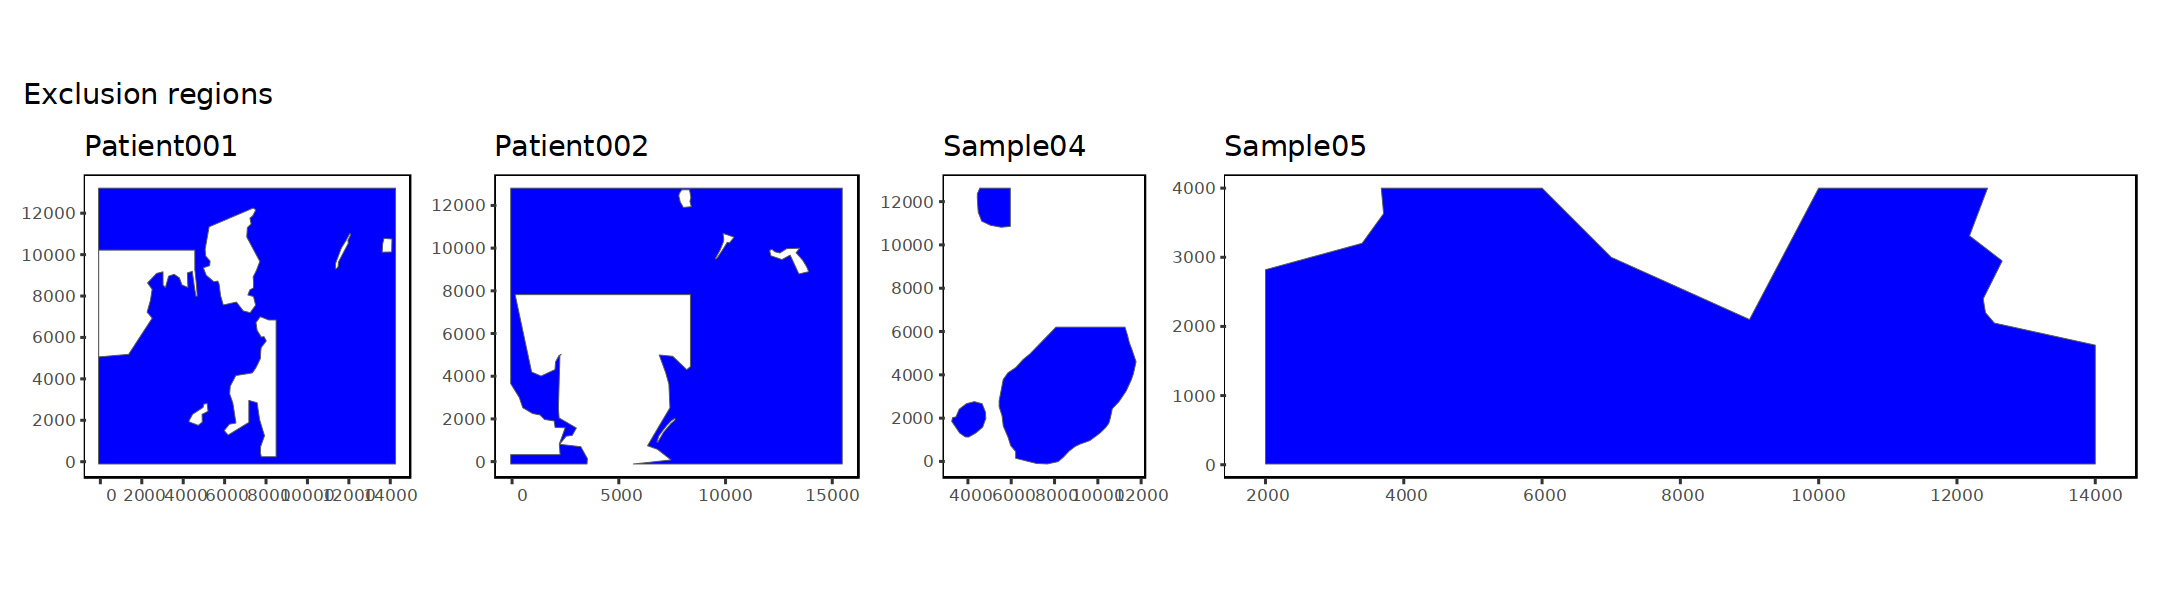

In [11]:
fig.size(5, 18)
regions_sf %>% 
    data.frame() %>% 
    split(.$library) %>% 
    imap(function(.SD, library) {
        st_sf(.SD) %>% 
            ggplot() + 
                # geom_sf(aes(geometry = area_exclude), fill = 'red') + 
                geom_sf(aes(geometry = area_include), fill = 'blue') + 
                labs(title = library) + 
                NULL
    }) %>% 
    purrr::reduce(`+`) + 
    plot_layout(nrow = 1) + 
    patchwork::plot_annotation(title = 'Exclusion regions')


## Plot

As a sanity chek, let's plot the tx and regions in place: 


In [ ]:
...

# Grid and quantify 




## Do grid

In [13]:
tiles <- map(unique(regions_sf$library), function(.library) {
    .regions = subset(regions_sf, library == .library)
    message(.library)
    # tiles = st_make_grid(.regions$bbox, cellsize = 50, square = TRUE) ## 2500um^2 square
    tiles = st_make_grid(.regions$bbox, cellsize = 53.7285, square = FALSE) ## 2500um^2 hex
    
    tiles = tiles[st_intersects(.regions$area_include, tiles)[[1]]]
    tiles = st_intersection(tiles, .regions$area_include)
    ## keep tiles that were cut by less than 2/3 
    tiles = tiles[which(st_area(tiles) >= max(st_area(tiles)) * 1/3)]
    return(st_sf(
        ID = paste0('tile', seq_len(length(tiles))), 
        library = .library, 
        tile = tiles
    ))        
    
}) %>% 
    bind_rows()
tiles$ID <- paste(tiles$ID, tiles$library, sep = '_')
## For convenience, attach centroids 
tiles <- cbind(tiles, st_coordinates(st_centroid(tiles))) 


Sample05

Patient001

Patient002

Sample04

Warning message in st_centroid.sf(tiles):
“st_centroid assumes attributes are constant over geometries of x”


In [14]:
head(tiles)

ID             library  X       Y        tile                          
1 tile1_Sample05 Sample05 2012.04 103.8809 POLYGON ((2000 73.00181, 20...
2 tile2_Sample05 Sample05 2012.04 196.9414 POLYGON ((2000 166.0623, 20...
3 tile3_Sample05 Sample05 2012.04 290.0019 POLYGON ((2000 259.1228, 20...
4 tile4_Sample05 Sample05 2012.04 383.0624 POLYGON ((2000 352.1833, 20...
5 tile5_Sample05 Sample05 2012.04 476.1229 POLYGON ((2000 445.2438, 20...
6 tile6_Sample05 Sample05 2012.04 569.1834 POLYGON ((2000 538.3043, 20...

In [15]:
nrow(tiles)

[1] 152108

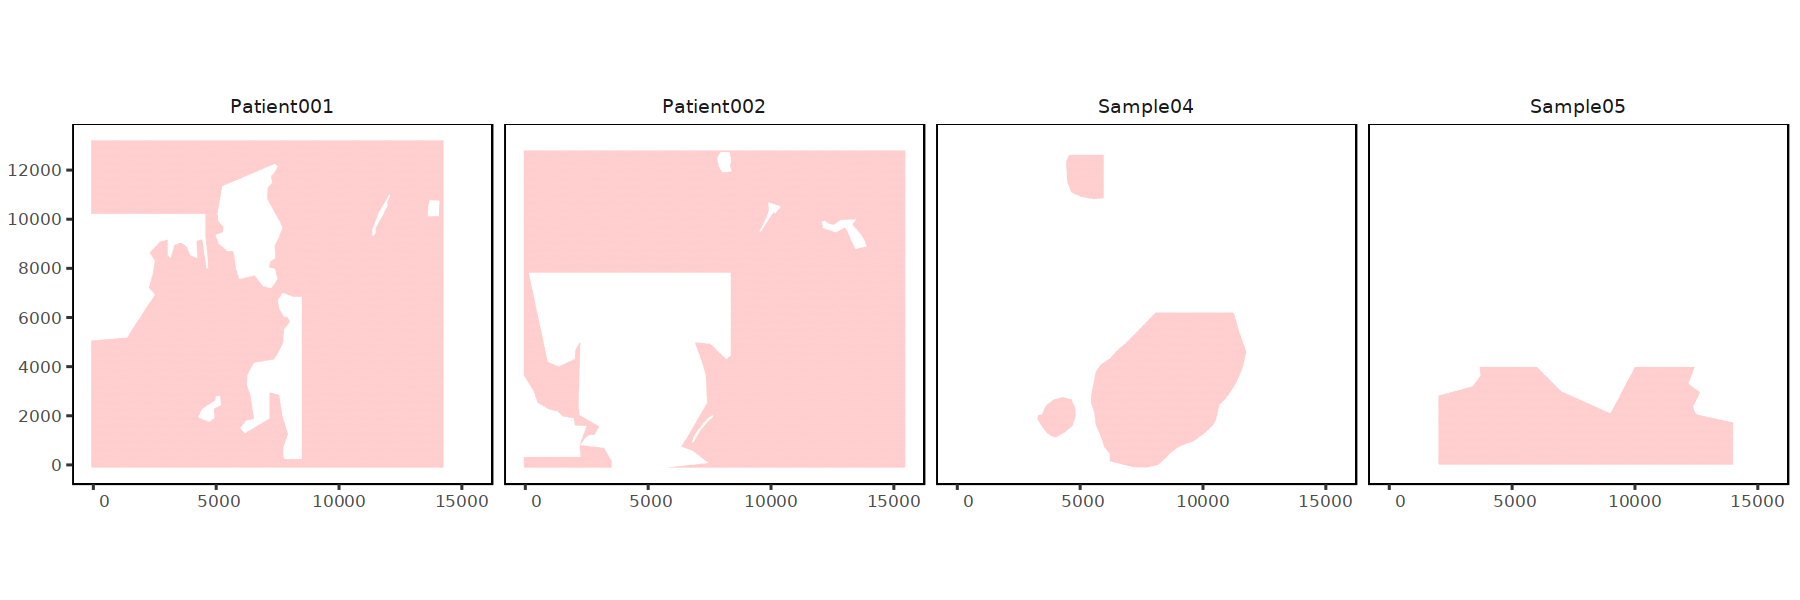

In [16]:
fig.size(5, 15)
ggplot() + 
    geom_sf(data = tiles, fill = 'red', alpha = .2, color = NA) + 
    facet_wrap(~library, nrow = 1) + 
    NULL


Zooming in: 

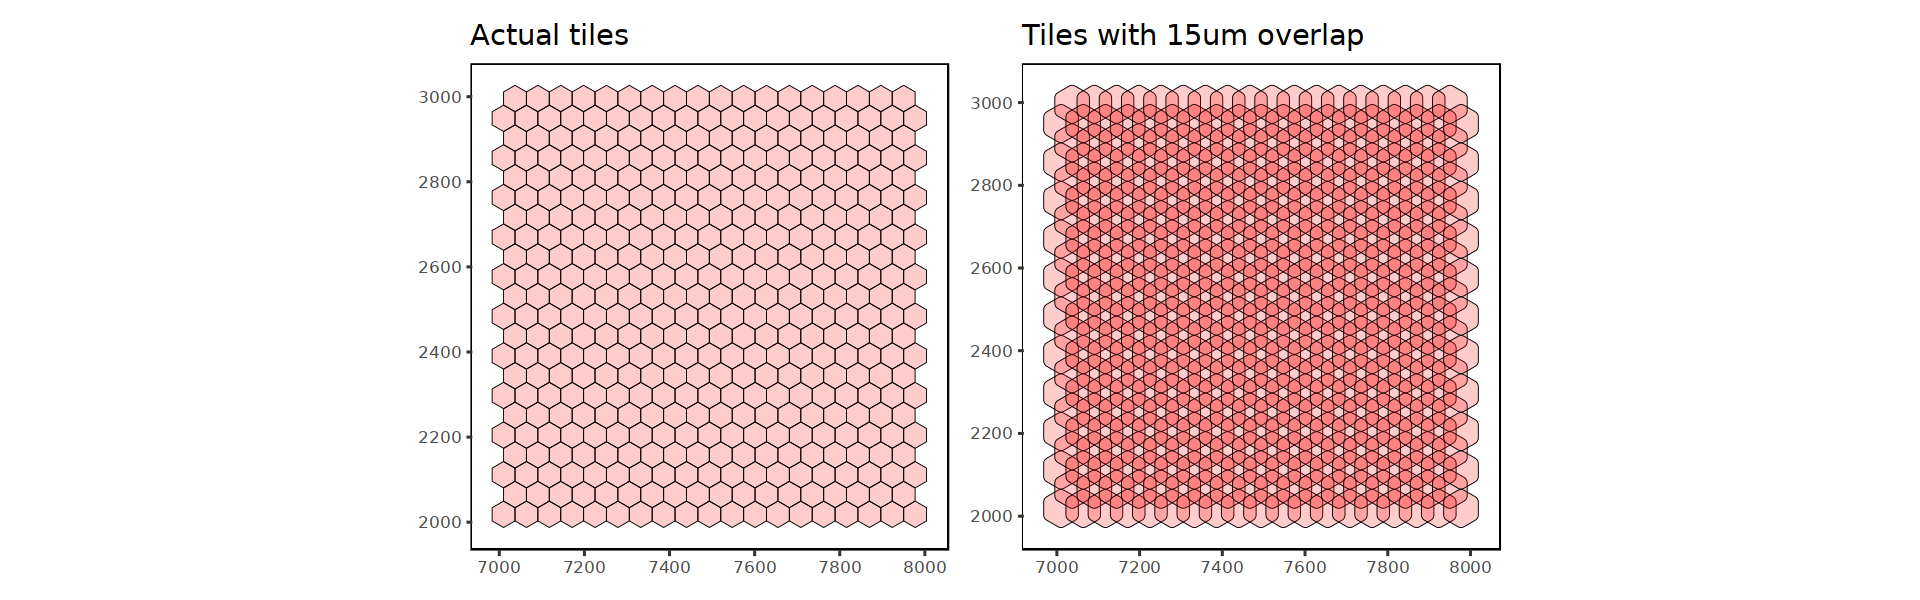

In [17]:
fig.size(5, 16)
ggplot() + 
    geom_sf(data = subset(tiles, library == 'Sample04' & between(X, 7000, 8000) & between(Y, 2000, 3000)) %>% st_buffer(0), fill = 'red', alpha = .2, color = 'black') + 
    labs(title = 'Actual tiles') + 
    NULL | 
ggplot() + 
    geom_sf(data = subset(tiles, library == 'Sample04' & between(X, 7000, 8000) & between(Y, 2000, 3000)) %>% st_buffer(15), fill = 'red', alpha = .2, color = 'black') + 
    labs(title = 'Tiles with 15um overlap') + 
    NULL


In [18]:
head(tiles)

ID             library  X       Y        tile                          
1 tile1_Sample05 Sample05 2012.04 103.8809 POLYGON ((2000 73.00181, 20...
2 tile2_Sample05 Sample05 2012.04 196.9414 POLYGON ((2000 166.0623, 20...
3 tile3_Sample05 Sample05 2012.04 290.0019 POLYGON ((2000 259.1228, 20...
4 tile4_Sample05 Sample05 2012.04 383.0624 POLYGON ((2000 352.1833, 20...
5 tile5_Sample05 Sample05 2012.04 476.1229 POLYGON ((2000 445.2438, 20...
6 tile6_Sample05 Sample05 2012.04 569.1834 POLYGON ((2000 538.3043, 20...

## quantify transcripts (within hex)

In [19]:
## map uses too much memory - for loop is better here 
libs <- unique(regions_sf$library)
colname_x = 'x'
colname_y = 'y'
colname_ptname = 'gene'
colname_shapename = 'ID'

counts_list <- list()
for (i in 1:4) {
    .library = libs[i]
    message(.library)
    .tx_dt <- tx[library == .library]
    .shapes_sf = subset(tiles, library == .library)

    pt_names <- .tx_dt[[colname_ptname]]
    overlap_res <- st_contains(st_geometry(.shapes_sf), st_geometry(st_as_sf(.tx_dt, coords = c(colname_x, colname_y))))
    overlap_res <- map(overlap_res, function(i) pt_names[i])
    res <- data.table(shape_id = as.character(.shapes_sf[[colname_shapename]]), pt_names = overlap_res, key = "shape_id")    
    counts_list[[i]] <- tx_to_counts2(res, "pt_names", "shape_id")
    rm(.tx_dt); rm(.shapes_sf); rm(res); rm(overlap_res); gc()
}
counts <- Reduce(Matrix::cbind2, counts_list)
rm(counts_list); gc()

Sample05

Patient001

Patient002

Sample04



used       (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells    5574881  297.8  250920182 13400.6  490078478 26173.1
Vcells 1057053311 8064.7 3520928780 26862.6 3008537621 22953.4

In [20]:
## remove blanks
## and align to tiles
counts <- counts[rownames(counts)[!grepl('Blank', rownames(counts))], tiles$ID]


In [21]:
dim(counts)
counts[1:5, 1:5]

[1]    479 152108

5 x 5 sparse Matrix of class "dgCMatrix"
      tile1_Sample05 tile2_Sample05 tile3_Sample05 tile4_Sample05
ACE                .              .              .              .
ACKR1              .              .              .              .
ACKR2              .              .              .              .
ACKR3              .              .              .              .
ACKR4              .              .              .              .
      tile5_Sample05
ACE                .
ACKR1              .
ACKR2              .
ACKR3              .
ACKR4              .

## quantify transcripts (with some bleedthrough)

In [22]:
## map uses too much memory - for loop is better here 
libs <- unique(regions_sf$library)
colname_x = 'x'
colname_y = 'y'
colname_ptname = 'gene'
colname_shapename = 'ID'

counts_list <- list()
for (i in 1:4) {
    .library = libs[i]
    message(.library)
    .tx_dt <- tx[library == .library]
    .shapes_sf = subset(tiles, library == .library)
    .shapes_sf = st_buffer(.shapes_sf, 15)

    pt_names <- .tx_dt[[colname_ptname]]
    overlap_res <- st_contains(st_geometry(.shapes_sf), st_geometry(st_as_sf(.tx_dt, coords = c(colname_x, colname_y))))
    overlap_res <- map(overlap_res, function(i) pt_names[i])
    res <- data.table(shape_id = as.character(.shapes_sf[[colname_shapename]]), pt_names = overlap_res, key = "shape_id")    
    counts_list[[i]] <- tx_to_counts2(res, "pt_names", "shape_id")
    rm(.tx_dt); rm(.shapes_sf); rm(res); rm(overlap_res); gc()
}
counts_conv <- Reduce(Matrix::cbind2, counts_list)
rm(counts_list); gc()

Sample05

Patient001

Patient002

Sample04



used       (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells    5580978  298.1  237948228 12707.9  490078478 26173.1
Vcells 1086796859 8291.7 3520928780 26862.6 3511346757 26789.5

In [23]:
## remove blanks
## and align to tiles
counts_conv <- counts_conv[rownames(counts_conv)[!grepl('Blank', rownames(counts_conv))], tiles$ID]


In [24]:
dim(counts_conv)
counts_conv[1:5, 1:5]

[1]    479 152108

5 x 5 sparse Matrix of class "dgCMatrix"
      tile1_Sample05 tile2_Sample05 tile3_Sample05 tile4_Sample05
ACE                .              .              .              .
ACKR1              .              .              .              .
ACKR2              .              .              .              .
ACKR3              .              .              .              .
ACKR4              .              .              .              .
      tile5_Sample05
ACE                .
ACKR1              .
ACKR2              .
ACKR3              .
ACKR4              .

## Filter low count tiles 

In [25]:
tiles$ntx <- colSums(counts)


Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 80190 rows containing non-finite values (`stat_bin()`).”


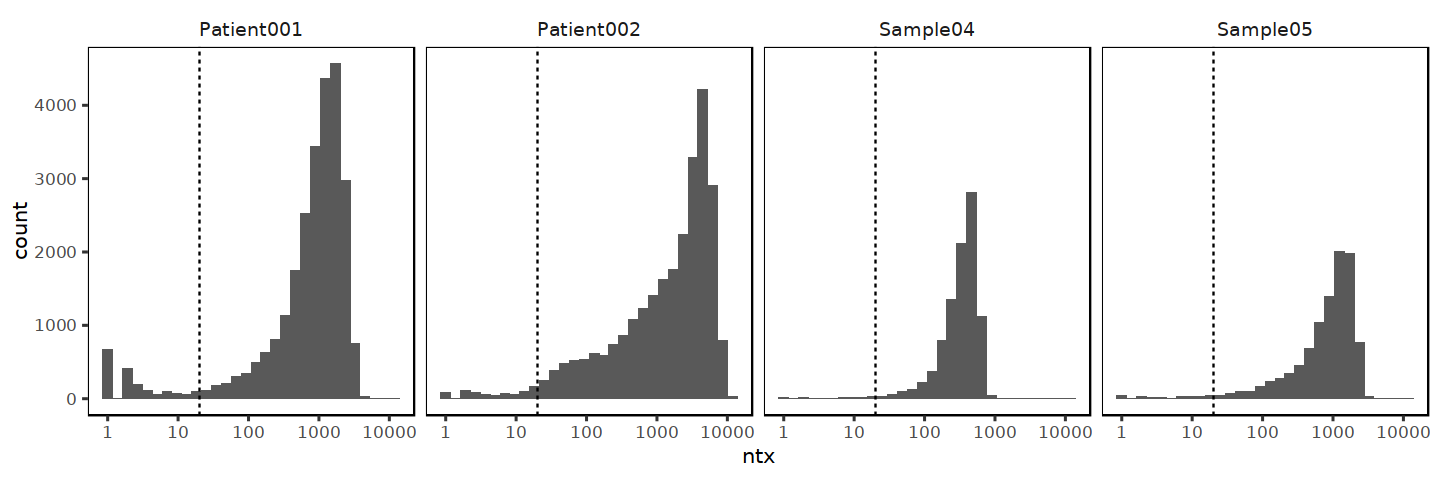

In [26]:
fig.size(4, 12)
tiles %>% 
    st_drop_geometry() %>% 
    ggplot(aes(ntx)) + 
        geom_histogram() + 
        scale_x_log10() + 
        facet_wrap(~library, nrow = 1) + 
        geom_vline(xintercept = 20, linetype = 2) + 
        NULL


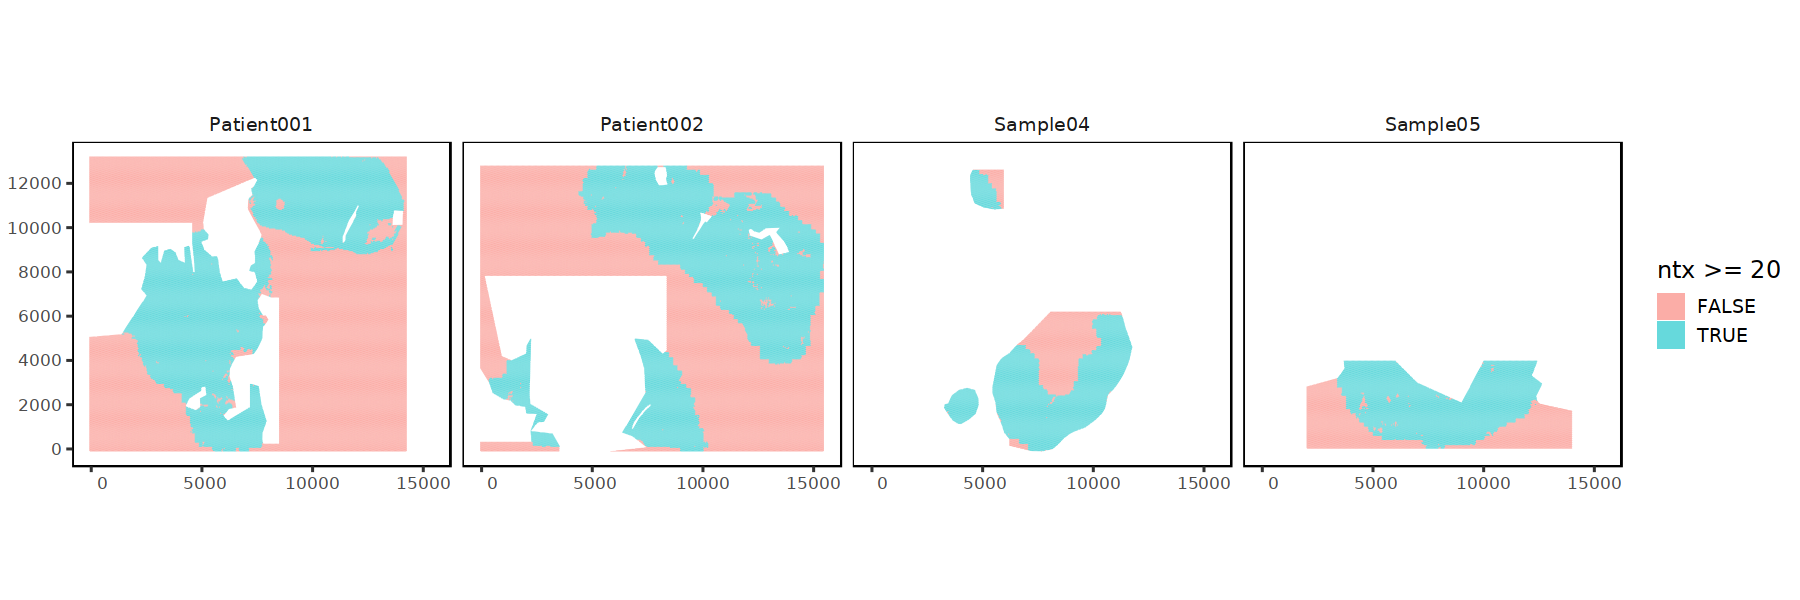

In [27]:
fig.size(5, 15)
ggplot() + 
    geom_sf(data = tiles, aes(fill = ntx >= 20), alpha = .6, color = NA) + 
    # geom_sf(data = tiles, fill = 'red', alpha = .2, color = NA) + 
    facet_wrap(~library, nrow = 1) + 
    NULL


In [28]:
i = which(tiles$ntx >= 20)
tiles = tiles[i, ]
counts = counts[, i]
counts_conv = counts_conv[, i]


In [ ]:
fig.size(5, 15)
ggplot() + 
    geom_sf(data = tiles, alpha = 1, color = NA) + 
    facet_wrap(~library, nrow = 1) + 
    NULL


## assign "true" label

In [30]:
dir <- '/n/data1/bwh/medicine/korsunsky/lab/data/VizgennsclcNirdata/lung/'
region_fnames <- file.path(dir, c(
    '202206221552_HuLungCancer-VS13-Sample04-CC3-CP-MET_Beta10/hybrid_hubs.parquet',
    '202208221332_HuLungCancer-VS13-CC3-Patient002-CP-MET_Beta8/region_0/Lung002_region0_hybrid_hub_regions.parquet',
    '202208221332_HuLungCancer-VS13-CC3-Patient002-CP-MET_Beta8/region_1/Lung002_region1_hybrid_hub_regions.parquet',
    '202208241341_HuLungCancer-VS13-CC3-Patient001-CP-MET_Beta8/region_0/Lung001_hybrid_hub_regions.parquet',
    'Lung005/Lung005_hybrid_hub_regions.parquet',
    '202206221552_HuLungCancer-VS13-Sample04-CC3-CP-MET_Beta10/tumor_regions.parquet',
    '202208221332_HuLungCancer-VS13-CC3-Patient002-CP-MET_Beta8/region_0/Lung002_region0_tumor_regions.parquet',
    '202208221332_HuLungCancer-VS13-CC3-Patient002-CP-MET_Beta8/region_1/Lung002_region1_tumor_regions.parquet',
    '202208241341_HuLungCancer-VS13-CC3-Patient001-CP-MET_Beta8/region_0/Lung001_tumor_regions.parquet',
    'Lung005/Lung005_tumor_regions.parquet'
))


regions_list <- map(region_fnames, st_read_parquet)
names(regions_list) <- gsub(paste0(dir, '/'), '', region_fnames)
regions_df <- regions_list %>% 
    bind_rows(.id = 'fname') %>% 
    dplyr::mutate(
        type = case_when(
            grepl('tumor', fname) ~ 'tumor',
            grepl('hub', fname) ~ 'hub'
        ),
        library = case_when(
            grepl('Patient001', fname) ~ 'Patient001',
            grepl('Patient002', fname) ~ 'Patient002',
            grepl('Sample04', fname) ~ 'Sample04',
            grepl('Lung005', fname) ~ 'Sample05',
            TRUE ~ '-------------'
        )
    )
regions_df$ID <- paste0('R', 1:nrow(regions_df))

regions_df <- regions_df %>% split(.$library) %>% map(function(.regions) {
    buffers <- .regions %>% subset(type == 'hub') %>% st_geometry() %>% st_buffer(200) %>% st_union() %>% st_sfc()
    shapes_cut <- map(st_geometry(.regions), st_difference, buffers) %>% map(st_union)
    i <- which(.regions$type == 'tumor')
    .regions$geometry[i] <- shapes_cut[i]
    return(.regions)
}) %>% 
bind_rows()
    

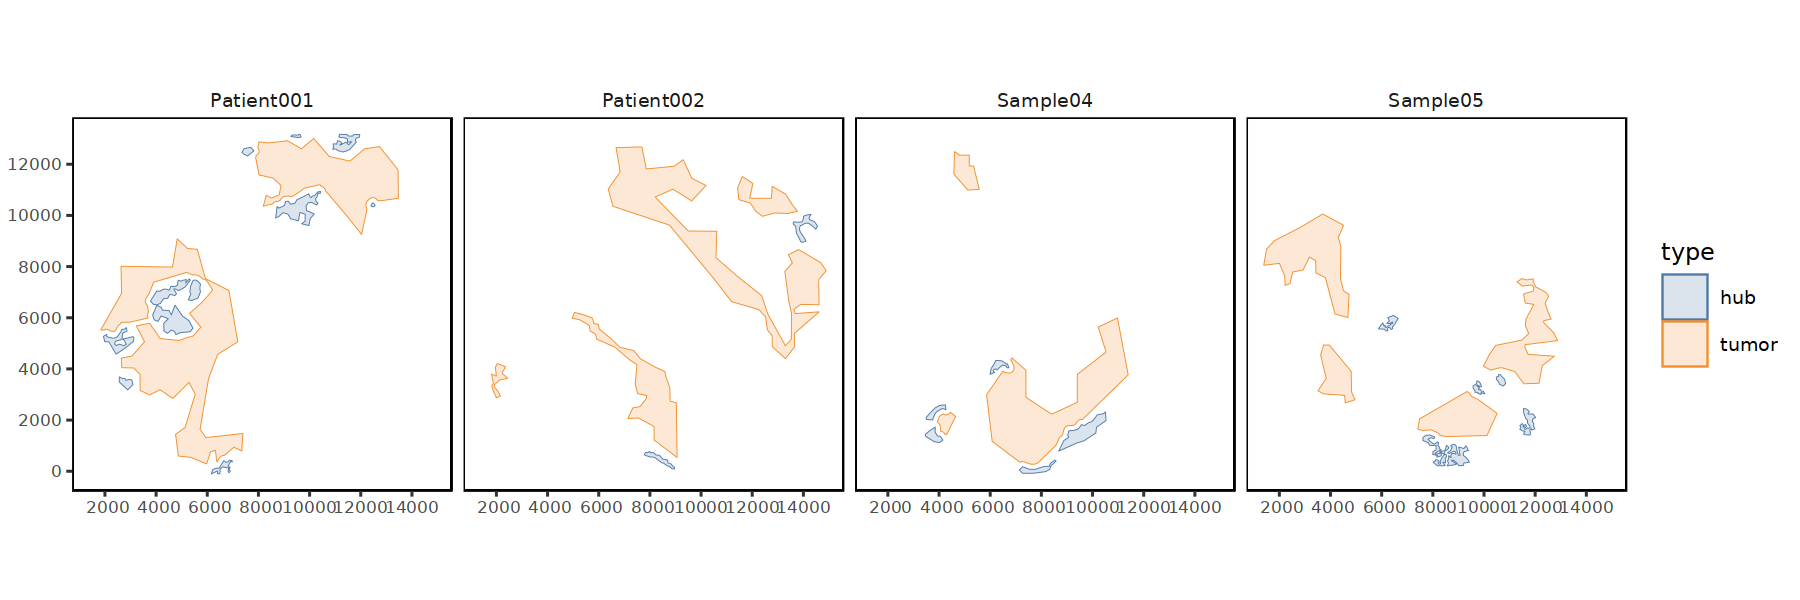

In [31]:
fig.size(5, 15)
ggplot() + 
    geom_sf(data = regions_df, aes(color = type, fill = type), alpha = .2, size = 10) + 
    facet_wrap(~library, nrow = 1) + 
    scale_color_tableau() + 
    scale_fill_tableau() + 
    NULL



In [32]:
tiles <- map(unique(tiles$library), function(.library) {
    tiles %>% 
        subset(library == .library) %>% 
        st_join(
            dplyr::select(subset(regions_df, library == .library), type), 
            largest = TRUE
        )
}) %>% 
    bind_rows()


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [33]:
## preserved order? 
all(tiles$ID == colnames(counts))

[1] TRUE

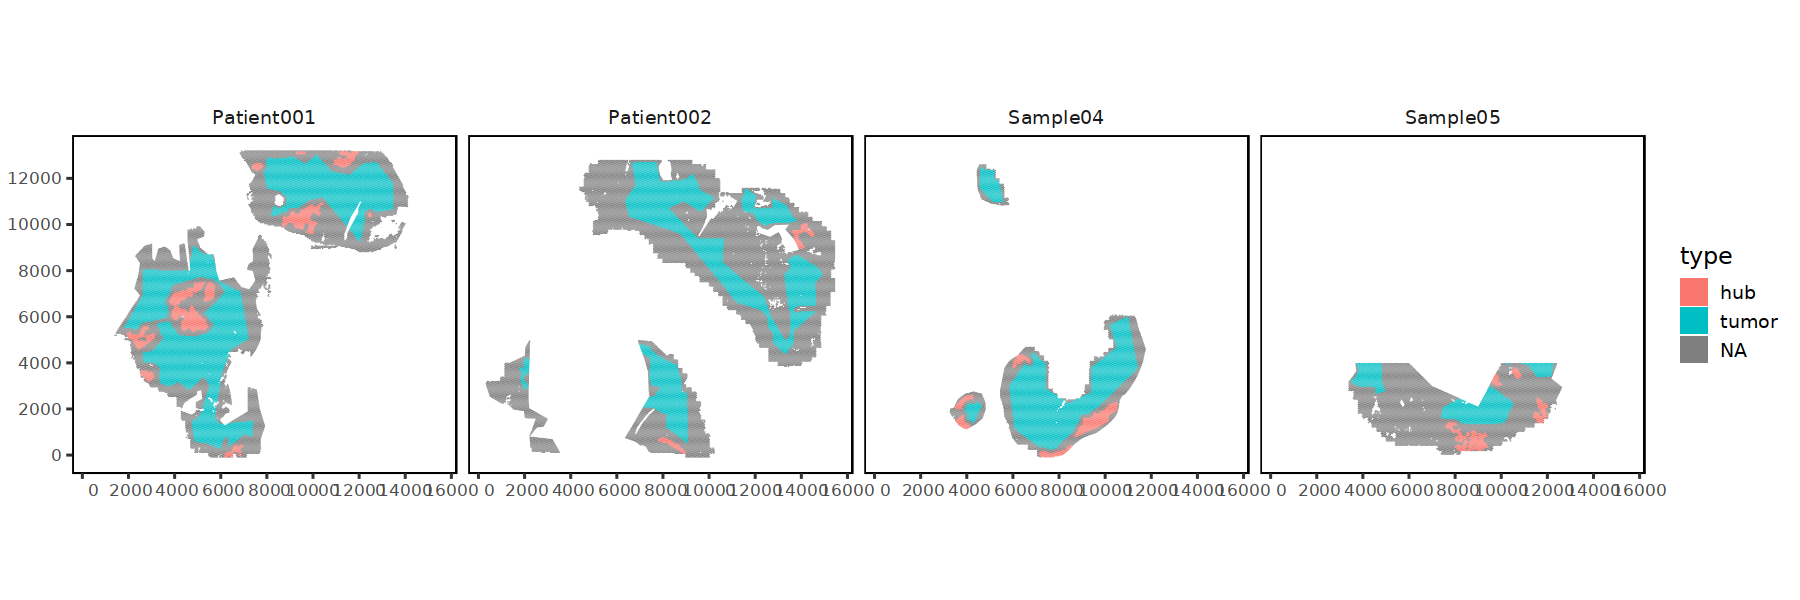

In [35]:
fig.size(5, 15)
ggplot() + 
    geom_sf(data = tiles, aes(fill = type), alpha = 1, color = NA) + 
    facet_wrap(~library, nrow = 1) + 
    NULL


## Cache

In [36]:
writeMM_fast(counts_conv, 'lung_n4/grid/counts_conv.mtx')
writeLines(rownames(counts_conv), 'lung_n4/grid/genes_conv.txt')
writeMM_fast(counts, 'lung_n4/grid/counts.mtx')
writeLines(rownames(counts), 'lung_n4/grid/genes.txt')
st_write_parquet(dplyr::select(tiles, tile), 'lung_n4/grid/shapes.parquet')
tiles %>% 
    st_drop_geometry() %>% 
    # cbind(st_coordinates(st_centroid(tiles))) %>% 
    fwrite('lung_n4/grid/tiles.csv', sep = ',')


Warning message:
“This is an initial implementation of Parquet/Feather file support and
geo metadata. This is tracking version 0.1.0 of the metadata
(https://github.com/geopandas/geo-arrow-spec). This metadata
specification may change and does not yet make stability promises.  We
do not yet recommend using this in a production setting unless you are
able to rewrite your Parquet/Feather files.”


# Cluster and label

## Data

In [2]:
meta_data <- fread('lung_n4/grid/tiles.csv')
# counts <- readMM_fast('lung_n4/grid/counts.mtx')
# rownames(counts) <- readLines('lung_n4/grid/genes.txt')
# colnames(counts) <- meta_data$ID
shapes <- st_read_parquet('lung_n4/grid/shapes.parquet')$tile

counts <- readMM_fast('lung_n4/grid/counts_conv.mtx')
rownames(counts) <- readLines('lung_n4/grid/genes_conv.txt')
colnames(counts) <- meta_data$ID


In [3]:
meta_data <- meta_data %>% 
    dplyr::mutate(type = case_when(
        type == '' ~ 'other', 
        TRUE ~ type
    ))


In [4]:
table(meta_data$type)


  hub other tumor 
 3746 37934 27417 

In [5]:
head(meta_data)
nrow(meta_data)

ID                library  X        Y        ntx type 
1 tile1723_Sample05 Sample05 3397.185 2802.635  24 other
2 tile1724_Sample05 Sample05 3397.185 2895.696 155 other
3 tile1725_Sample05 Sample05 3397.185 2988.756  82 other
4 tile1726_Sample05 Sample05 3397.185 3081.817 271 other
5 tile1727_Sample05 Sample05 3397.213 3174.625  74 other
6 tile1758_Sample05 Sample05 3424.050 2849.165 555 other

[1] 69097

In [6]:
sum(counts@x)


[1] 265716452

## PCA

In [7]:
logcpx <- normalizeData(counts, median(colSums(counts)), 'log')


In [8]:
## Option 1: unweighted PCA
# pca_res <- weighted_pca(logcpx, rep(1, ncol(counts)), do_corr = FALSE) 

## Option 2: weight by sample ID
# y <- with(meta_data, paste(library, region_type, sep = '_'))
y <- meta_data$library
weights <- as.numeric(((1/table(y))[y]) * (length(y)/length(unique(y))))
system.time({
    pca_res <- singlecellmethods::weighted_pca(logcpx, weights, do_corr = FALSE)     
})


   user  system elapsed 
 19.375   6.232   4.909 

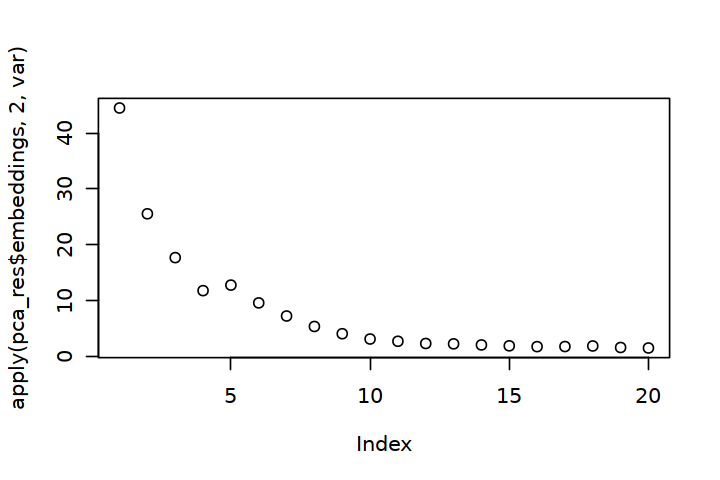

In [9]:
fig.size(4, 6)
plot(apply(pca_res$embeddings, 2, var))


In [10]:
system.time({
    ## Standard parameters 
    # U <- uwot::umap(pca_res$embeddings, min_dist = 0.1, spread = 0.3, ret_extra = 'fgraph')    
    
    ## Maxmize white space to highlight doublets 
    U <- uwot::umap(pca_res$embeddings, min_dist = 0.05, spread = 0.3, ret_extra = 'fgraph', approx_pow = TRUE, pcg_rand = FALSE, n_sgd_threads = 20)    
})



   user  system elapsed 
 64.897   0.847  19.252 

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


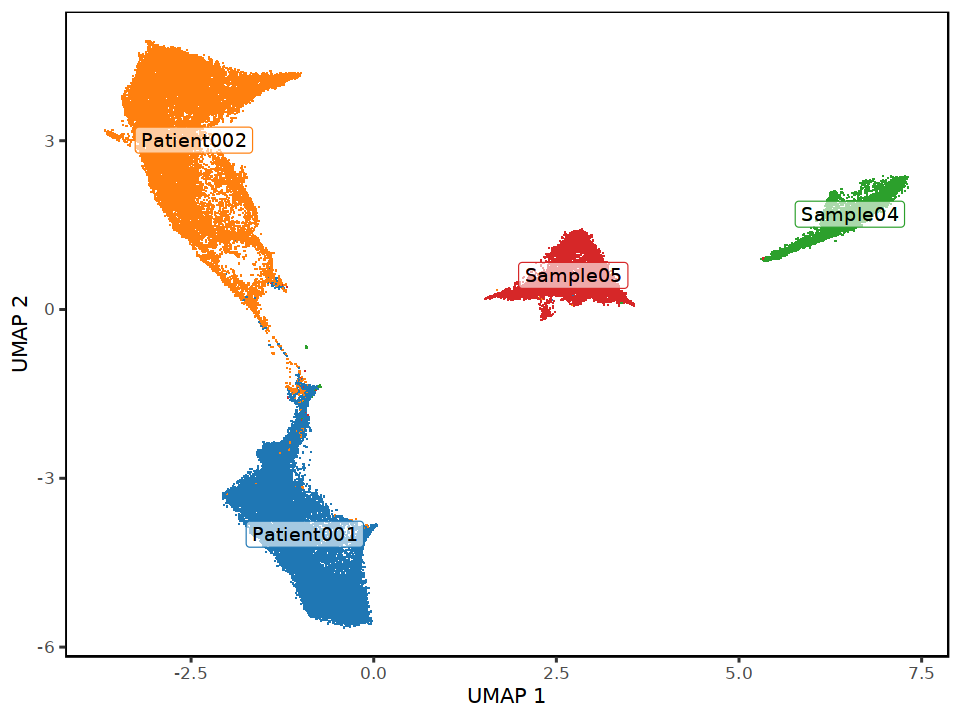

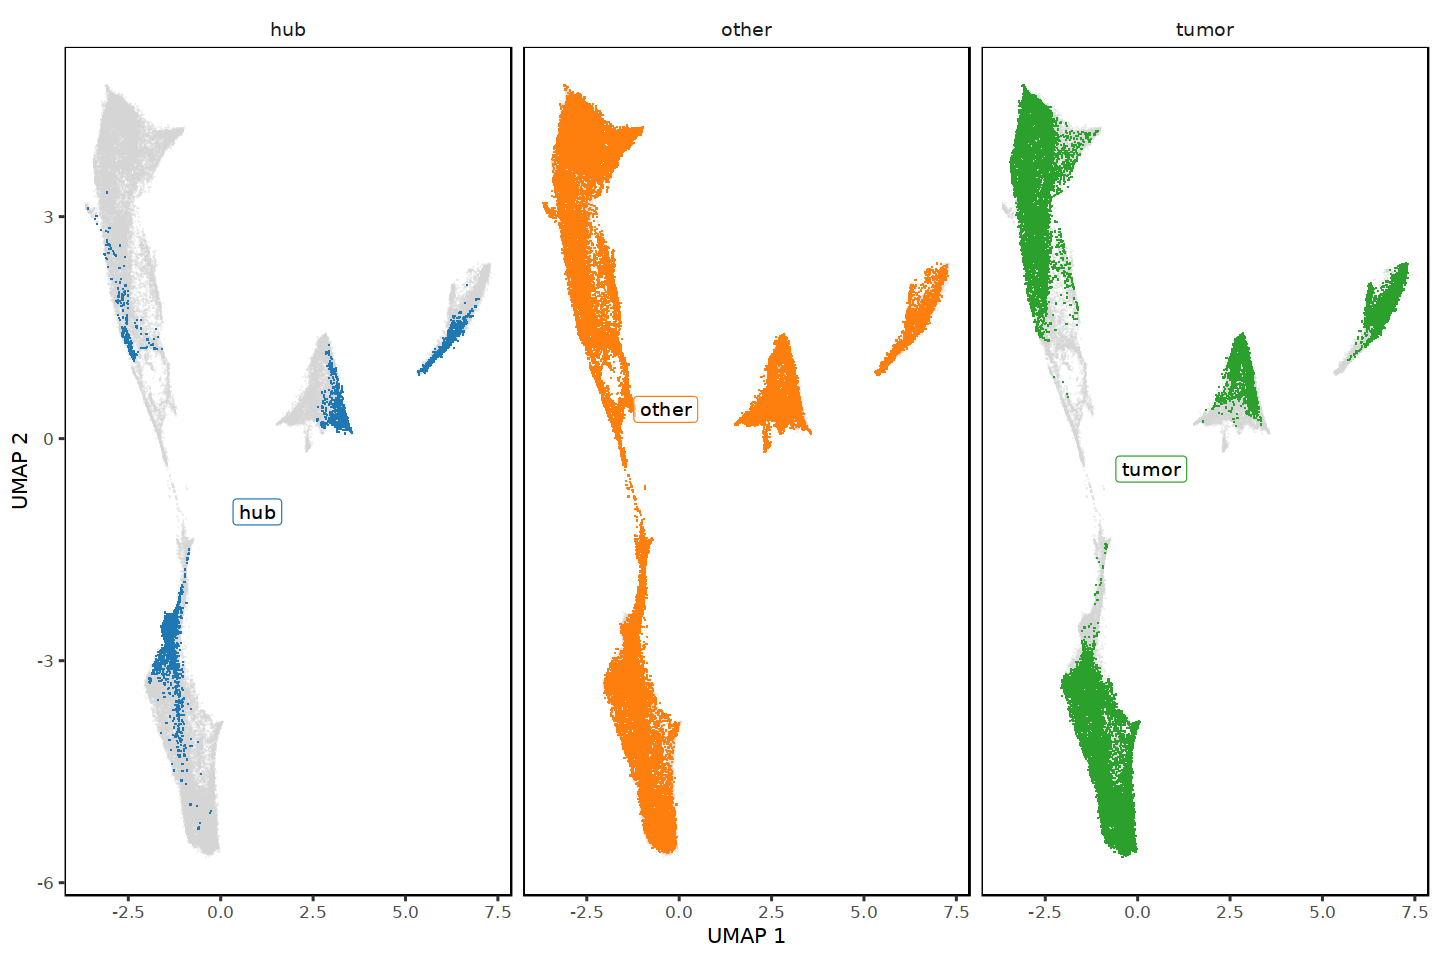

In [11]:
fig.size(6, 8)
do_scatter(U$embedding, meta_data, 'library', palette_use = tableau_color_pal('Classic 10')(4))

fig.size(8, 12)
do_scatter(U$embedding, meta_data, 'type', quo(type), nrow =1, palette_use = tableau_color_pal('Classic 10')(4)) 


## Harmonize


use_weights



[1] FALSE


use_weights

use_weights



[1] FALSE


use_weights

Harmony 1/5

Harmony 2/5

Harmony 3/5

Harmony 4/5

Harmony 5/5



    user   system  elapsed 
1094.421 1837.422  200.977 

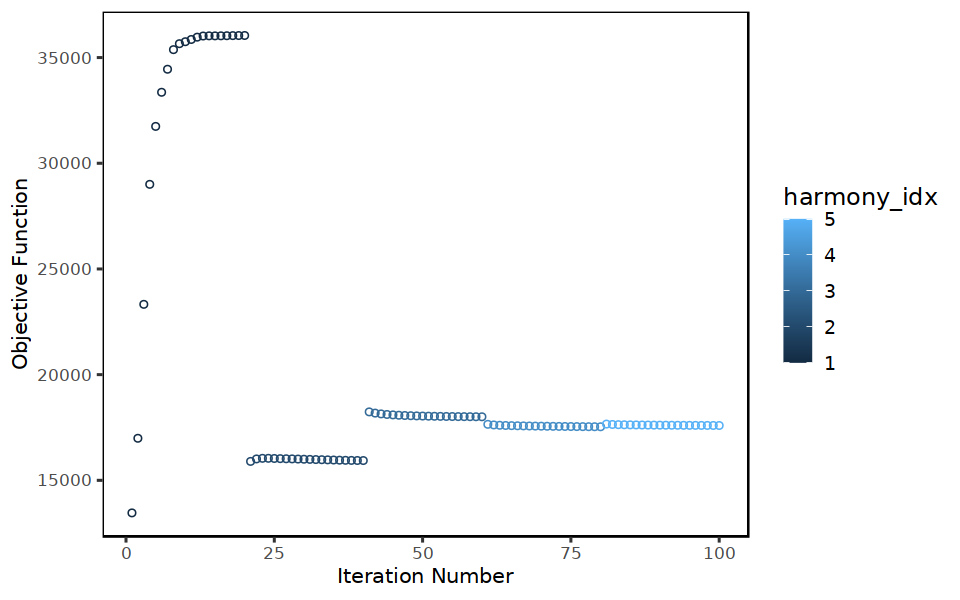

In [12]:
fig.size(5, 8)
system.time({
    harmony_res <- HarmonyMatrix(
        pca_res$embeddings, 
        meta_data, 'library', theta = .5, 
        do_pca = FALSE,
        # max.iter.harmony = 1, max.iter.cluster = 5, 
        max.iter.harmony = 5, max.iter.cluster = 20, 
        epsilon.cluster = -Inf, epsilon.harmony = -Inf, plot_convergence = TRUE, 
        return_object = TRUE
    )    
})


In [13]:
Z_corr = harmony_res$Z_corr
Z_cos = harmony_res$Z_cos
R = harmony_res$R

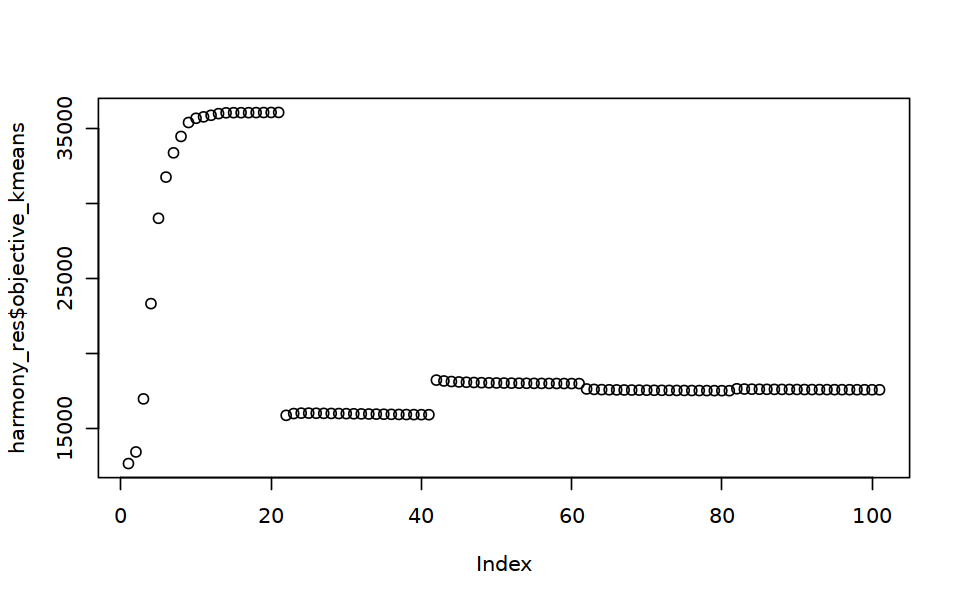

In [14]:
fig.size(5, 8)
plot(harmony_res$objective_kmeans)

In [15]:
system.time({
    U2 <- uwot::umap(t(harmony_res$Z_cos), min_dist = 0.05, spread = 0.30, ret_extra = 'fgraph', approx_pow = TRUE, pcg_rand = FALSE, n_sgd_threads = 20)  
})


   user  system elapsed 
 64.830   0.757  17.022 

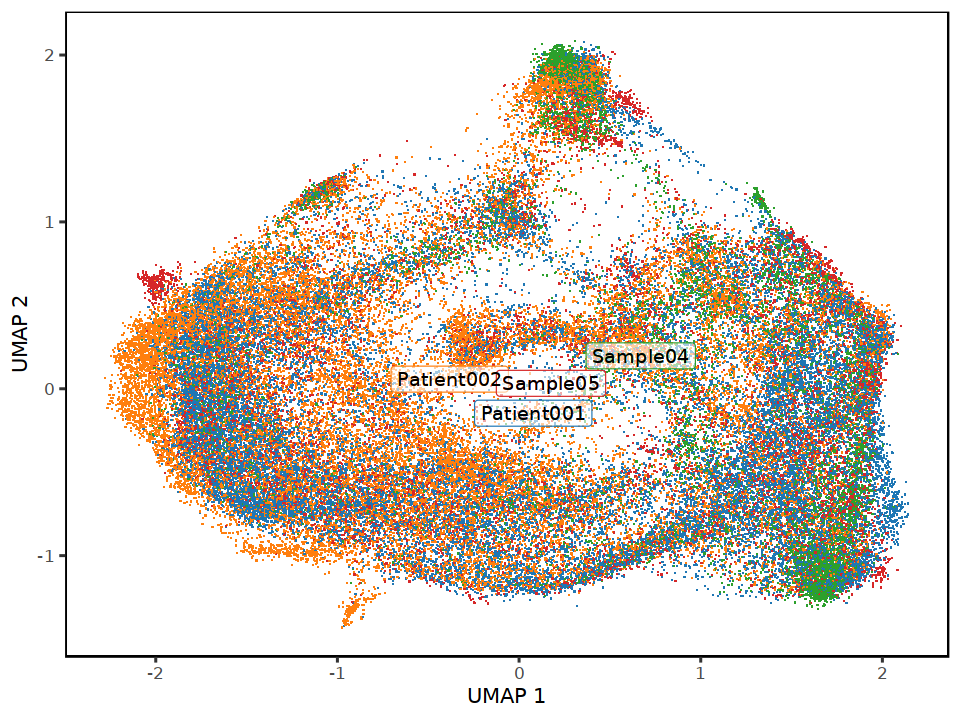

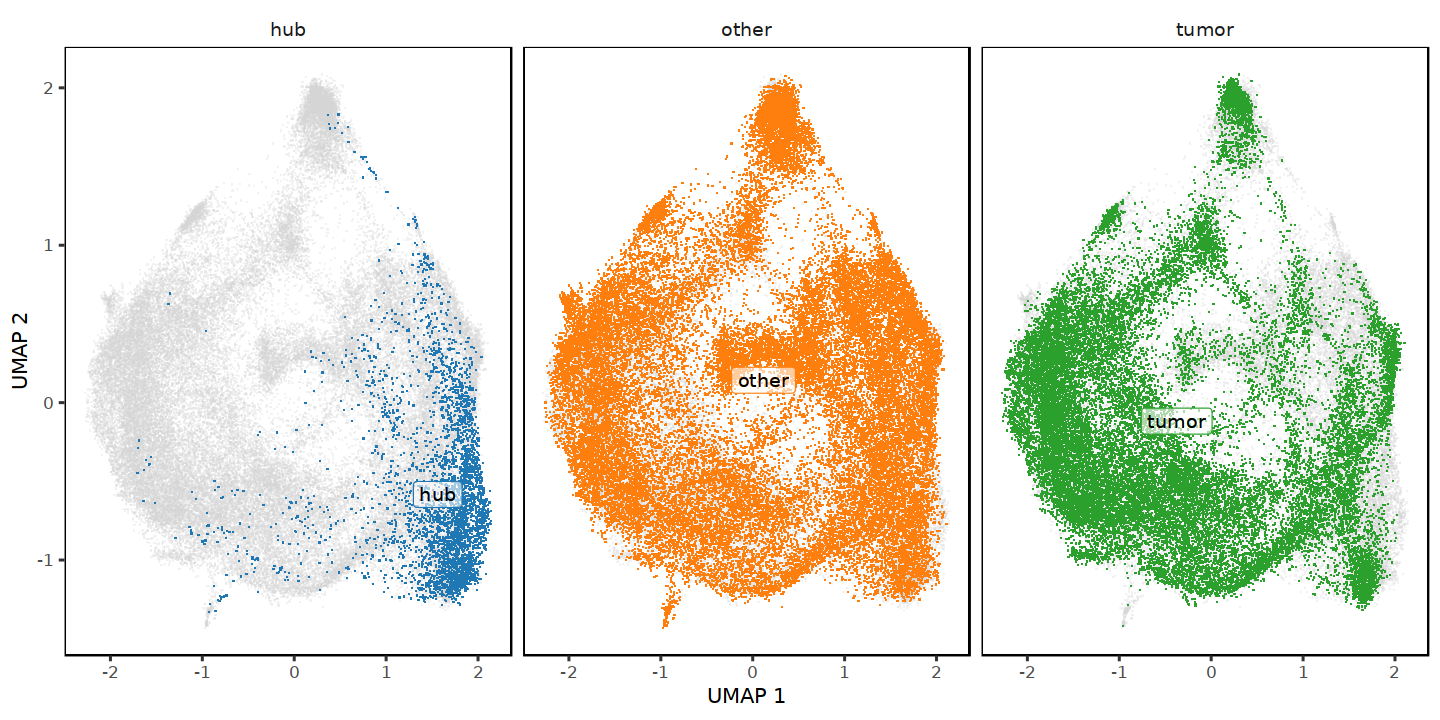

In [16]:
fig.size(6, 8)
do_scatter(U2$embedding, meta_data, 'library', palette_use = tableau_color_pal('Classic 10')(4))

fig.size(6, 12)
do_scatter(U2$embedding, meta_data, 'type', quo(type), nrow =1, palette_use = tableau_color_pal('Classic 10')(4)) 


## Clusters

In [ ]:
# X <- U2$fgraph
# diag(X) <- 1
# snn <- X %*% X
# snn <- snn + t(snn)


In [17]:
plan(multicore)
system.time({
    # clusters <- RunModularityClustering(snn, resolution = c(.1, .2, .4, .6, .8, 1.2, 1.5, 1.8, 2.1))
    clusters <- RunModularityClustering(U2$fgraph, resolution = c(.1, .2, .4, .6, .8, 1.2, 1.5, 1.8, 2.1))
    clusters <- map(clusters, function(x) x = factor(x, unique(as.integer(x)))) %>% bind_cols()     
})


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 69097
Number of edges: 754231

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9257
Number of communities: 3
Elapsed time: 12 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 69097
Number of edges: 754231

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8892
Number of communities: 4
Elapsed time: 16 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 69097
Number of edges: 754231

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8438
Number of communities: 7
Elapsed time: 20 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 69097
Number of edges: 754231

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8146
Number of communities: 10
Elapsed time: 20 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 69097
Number of edges: 754231

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7957
Number of communities: 14
Elapsed time: 21 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 69097
Number of edges: 754231

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7621
Number of communities: 20
Elapsed time: 22 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 69097
Number of edges: 754231

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7450
Number of communities: 22
Elapsed time: 24 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 69097
Number of edges: 754231

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7307
Number of communities: 25
Elapsed time: 25 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 69097
Number of edges: 754231

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7176
Number of communities: 30
Elapsed time: 25 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`


   user  system elapsed 
191.590   5.693  28.667 

In [18]:
map(map(clusters, table), length)

$Clust0.1
[1] 3

$Clust0.2
[1] 4

$Clust0.4
[1] 7

$Clust0.6
[1] 10

$Clust0.8
[1] 14

$Clust1.2
[1] 20

$Clust1.5
[1] 22

$Clust1.8
[1] 25

$Clust2.1
[1] 30

In [88]:
## Choose a resolution for downstream 
meta_data$cluster <- clusters$`Clust0.8`

## QC 

In [201]:
library(ggridges)

Picking joint bandwidth of 0.0594



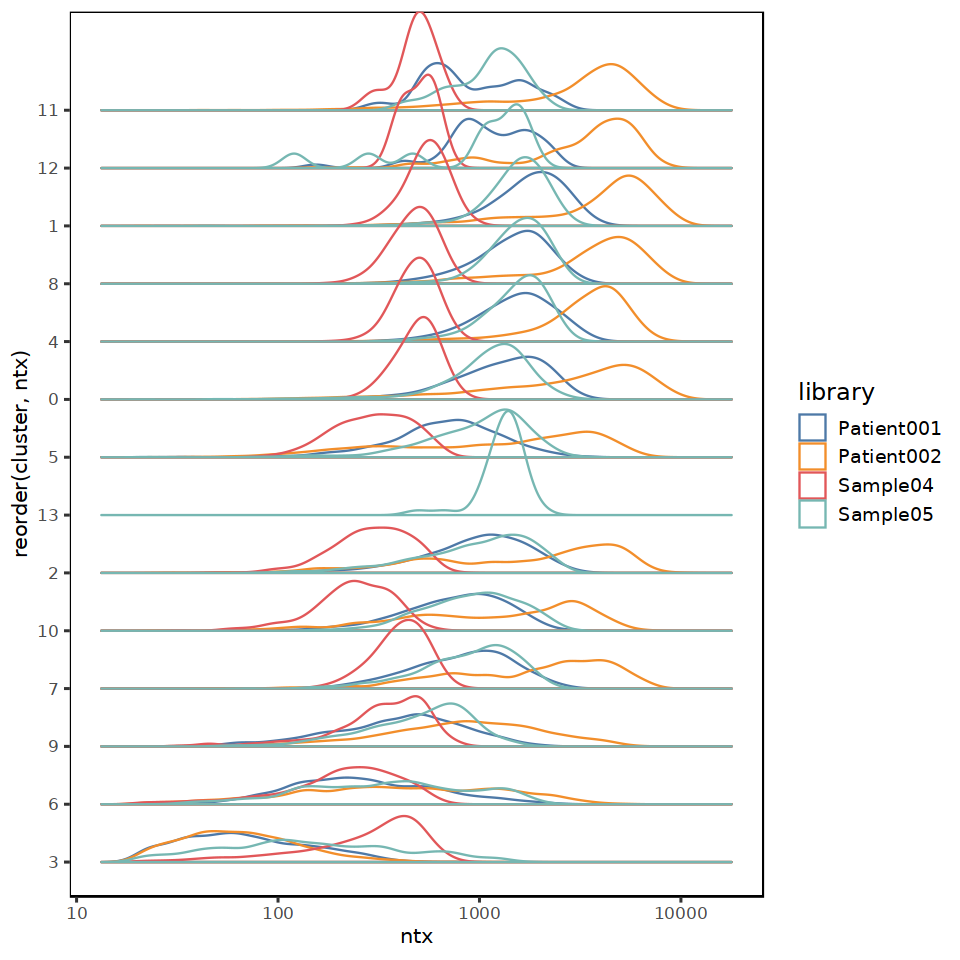

In [202]:
fig.size(8, 8)
meta_data %>%
    ggplot() + 
        geom_density_ridges2(aes(ntx, reorder(cluster, ntx), color = library), fill = NA) + 
        # geom_density_ridges2(aes(ntx, cluster, color = library, height = ..ndensity..), fill = NA) + 
        scale_color_tableau() + 
        scale_x_log10() + 
        NULL


## Proportions

Which clusters are shared vs dataset specific? 

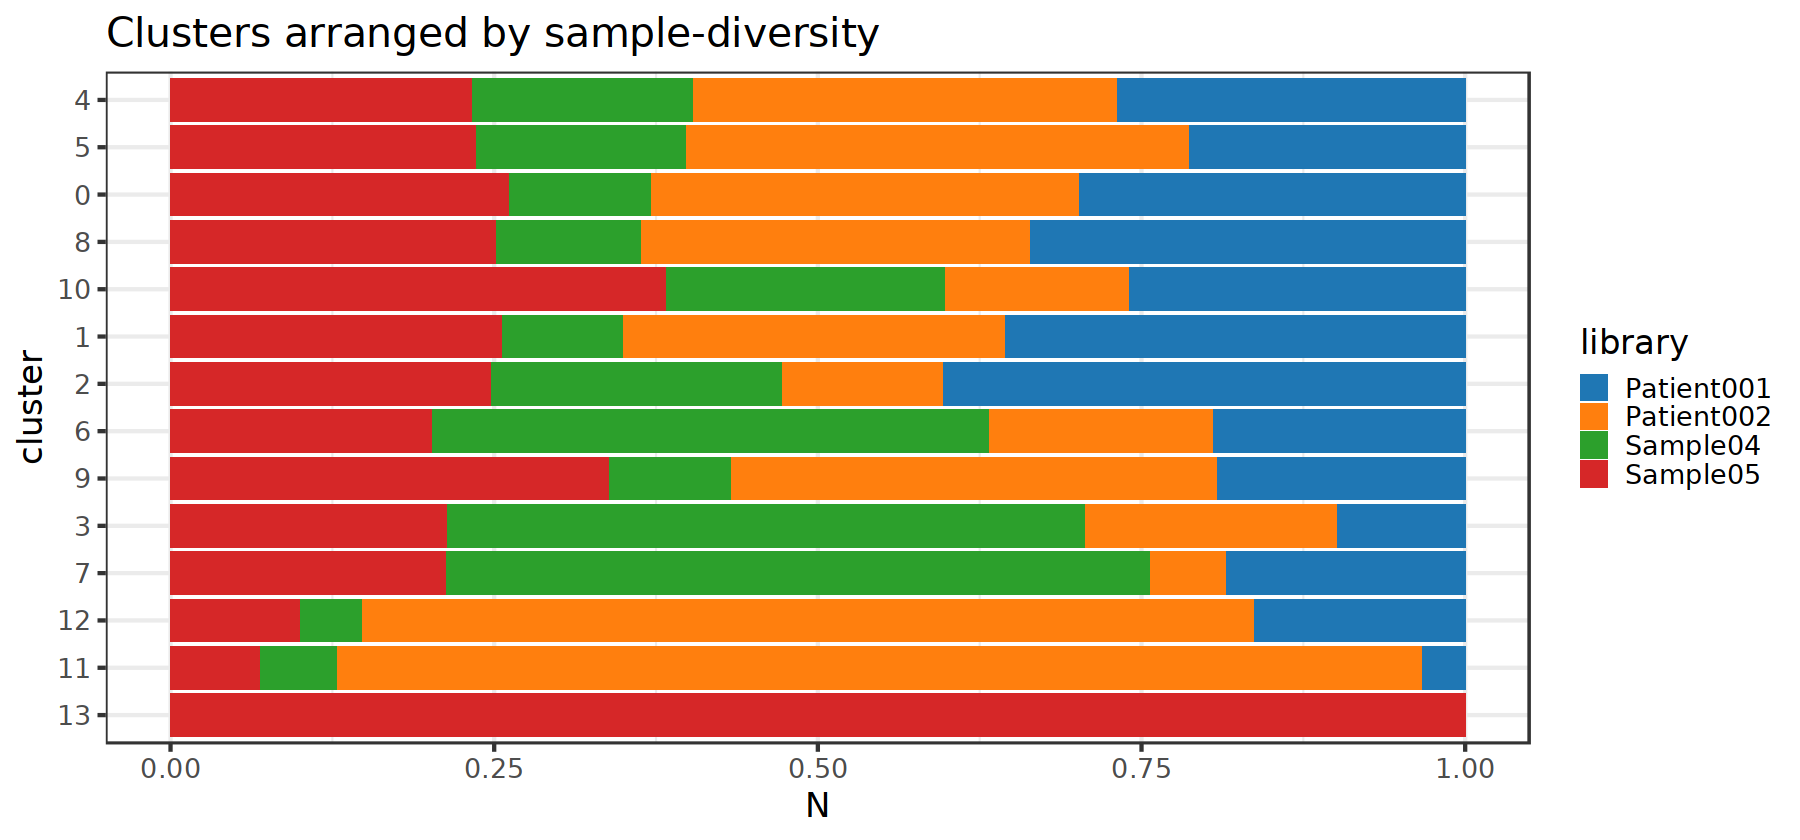

In [57]:
plt_df <- meta_data %>% 
    with(table(cluster, library)) %>% 
    prop.table(2) %>% prop.table(1) %>% 
    data.table() 

o = plt_df[, .(diversity = 1 / sum(N^2)), by = cluster][order(diversity), cluster]
plt_df <- plt_df %>% 
    dplyr::mutate(
    cluster = factor(cluster, o)
) 

fig.size(7, 15)
ggplot(plt_df, aes(cluster, N, fill = library)) + 
# ggplot(plt_df, aes(reorder(paste(region, library), lib_int), N, fill = type)) + 
    geom_bar(stat = 'identity', position = position_stack()) + 
    # coord_flip() + 
    scale_fill_tableau('Classic 10') + 
    coord_flip() + 
    theme_bw(base_size = 20) + 
    labs(title = 'Clusters arranged by sample-diversity') + 
    # facet_grid(.~region_type+library, scales = 'free', space = 'free') + 
    # facet_grid(region_type+library~., scales = 'free', space = 'free') + 
    NULL


In [58]:
clusters_shared <- as.character(plt_df[, .(diversity = 1 / sum(N^2)), by = cluster][diversity >= 1.5, cluster])

In [59]:
## These are the ones we're losing 
setdiff(meta_data$cluster, clusters_shared)


[1] "13" "11"

## Compare to ground truth

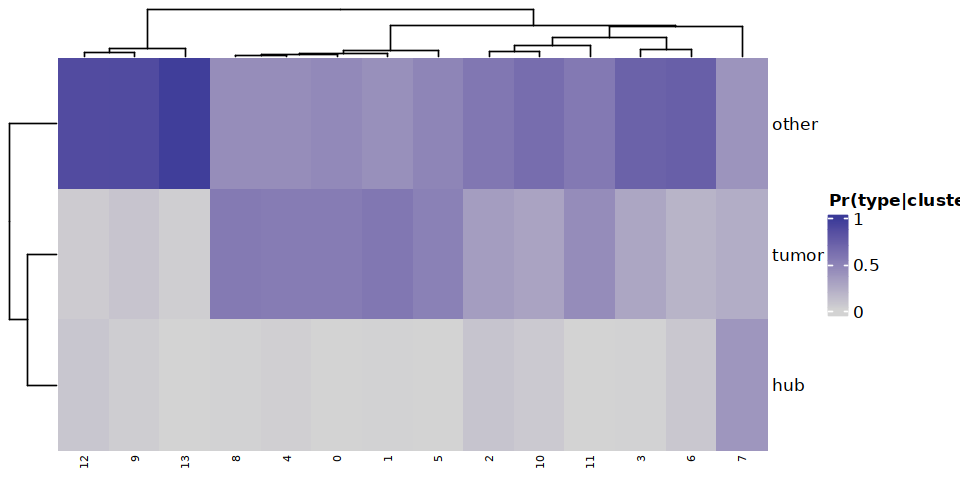

In [94]:
fig.size(4, 8)
meta_data %>% 
    with(table(type, cluster)) %>% 
    # prop.table(1) %>% ## Pr(cluster|type)
    prop.table(2) %>% ## Pr(type|cluster)
    Heatmap(
        col = colorRamp2(c(0, 0, 1), c('lightgrey', 'lightgrey', muted('blue'))),
        name = 'Pr(type|cluster)'
    )


## Markers (lme4)

The read depths are so different for each library, maybe we want to do some kind of regression thing for final "true" marker lists. 


In [37]:
pb <- presto::collapse_counts(counts, meta_data, c('library', 'cluster'), min_cells_per_group = 3, get_norm = TRUE)
pb$exprs_norm <- normalizeData(pb$counts_mat, 200, 'log')
pb$meta_data$cluster <- paste0('C', pb$meta_data$cluster)


CAREFUL: get_norm makes very strong assumptions about data



In [38]:
head(pb$meta_data)

library  cluster N    logUMI  
sample_31 Sample05 CC3      910 13.22502
sample_43 Sample05 CC6      718 13.72122
sample_3  Sample05 CC0     1447 15.26463
sample_27 Sample05 CC2      848 14.65647
sample_11 Sample05 CC10     966 14.71200
sample_55 Sample05 CC9      913 14.06175

In [39]:
library(lme4)
library(furrr)
library(future)
library(arm)

system.time({
    suppressWarnings({
        presto_res <- presto.presto(
            y ~ 1 + (1|cluster) + (1|cluster:library) + (1|library) + offset(logUMI), 
            pb$meta_data, 
            pb$counts_mat,
            size_varname = 'logUMI', 
            effects_cov = c('cluster', 'cluster:library', 'library'),
            ncore = 20, 
            min_sigma = .05, ## to avoid numerical instability from REs with 0 variance 
            family = 'poisson',
            nsim = 1000
        ) 
    })
})


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:patchwork’:

    area


The following object is masked from ‘package:dplyr’:

    select


The following object is masked from ‘package:spatstat.geom’:

    area



arm (Version 1.13-1, built: 2022-8-25)


Working directory is /n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish



Attaching package: ‘arm’


The following object is masked from ‘package:spatstat.geom’:

    rescale


The following object is masked from ‘package:scales’:

    rescale


CAUTION: if using GLMM, make sure your counts are integers!

Joining, by = "grpvar_orig"


   user  system elapsed 
580.864  37.858  34.214 

### Marginal

In [40]:
contrasts_mat <- make_contrast.presto(presto_res, 'cluster')
effects_marginal <- contrasts.presto(presto_res, contrasts_mat, one_tailed = TRUE) %>% 
    dplyr::mutate(cluster = contrast) %>% 
    dplyr::mutate(
        ## convert stats to log2 for interpretability 
        logFC = sign(beta) * log2(exp(abs(beta))),
        SD = log2(exp(sigma)),
        zscore = logFC / SD
    ) %>% 
    dplyr::select(cluster, feature, logFC, SD, zscore, pvalue) %>% 
    arrange(pvalue)
effects_marginal$fdr <- p.adjust(effects_marginal$pvalue, method = 'BH')


In [41]:
head(effects_marginal)

cluster feature  logFC    SD        zscore   pvalue       fdr         
1 CC9     REG1A    1.718721 0.2639909 6.510531 3.744289e-11 1.690070e-07
2 CC9     S100A12  1.932807 0.2989310 6.465732 5.040471e-11 1.690070e-07
3 CC9     CCL14    1.796322 0.2847412 6.308613 1.407739e-10 3.146766e-07
4 CC9     LILRA4   1.931496 0.3087473 6.255911 1.976009e-10 3.312779e-07
5 CC9     TNFSF13B 1.465151 0.2437476 6.010937 9.222688e-10 1.236947e-06
6 CC9     BEST4    1.754623 0.2964877 5.918030 1.629102e-09 1.818088e-06

In [45]:
effects_marginal %>% 
    subset(fdr < .2 & logFC > 0) %>% 
    # subset(cluster %in% c('C4', 'C7', 'C9')) %>% 
    # dplyr::mutate(cluster = factor(cluster, paste0('C', 0:13))) %>% 
    split(.$cluster) %>% 
    map(function(.SD) {
        .SD %>% 
            # dplyr::arrange(-zscore) %>% 
            dplyr::arrange(-logFC) %>% 
            head(20) %>% 
            dplyr::select(feature, cluster) %>% 
            tibble::rowid_to_column('rank')
    }) %>% 
    bind_rows() %>% 
    tidyr::spread(cluster, feature) %>% 
    dplyr::select(-rank) %>% 
    t() %>% 
    identity()

[,1]   [,2]    [,3]   [,4]   [,5]   [,6]     [,7]    [,8]   [,9]  
CC0  LCN2   MET     RNF43  RORC   OSMR   VEGFA    KRT8    ETV4   TM4SF1
CC1  MET    ETV4    ANXA1  RNF43  UBE2C  TOP2A    MKI67   KRT8   PTTG1 
CC10 SFRP2  COL10A1 MMP2   MZB1   COL3A1 CD79A    TAGLN   ACTA2  VCAN  
CC11 PTTG1  MKI67   TOP2A  ETV4   EPHB3  RORC     UBE2C   CDCA7  PCNA  
CC12 CD1C   CCL17   CD1E   S100B  RNF43  CKB      CCL19   CSF2RB TNF   
CC13 MS4A1  CPA3    CD1E   FCER1A CCR7   CXCL1    SIGLEC6 BIRC3  MS4A2 
CC2  GJA4   VWF     COL4A1 RGS5   S1PR1  NOTCH4   PDGFRB  SFRP2  SEMA3G
CC3  FZD1   SPP1    MMP12  PDCD1  IL23R  VEGFA    CCL14   CA12   CMTM2 
CC4  CXCL10 MARCO   ZNF683 CXCL11 C1QC   C1QB     MSR1    MS4A4A GBP1  
CC5  SPP1   MMP12   MARCO  VEGFA  CA12   SERPINE1 CXCL8   LAMB3  ITGAX 
CC6  SPP1   CA1     FOSB   CTSG   LYZ    CD14     PDCD1   GPNMB  C1QA  
CC7  CCR7   MS4A1   SELL   IL7R   CD247  MZB1     CD79A   TCF7   CD27  
CC8  GJA4   COL4A1  RGS5   PDGFRB ESM1   NOTCH4   CSPG4   CD34   S1PR3 
CC9  PDCD1  S100A12 LILRA4 FLI1   CD69   CCL14    TGFBR3  BEST4  REG1A 
     [,10]    [,11]  [,12]  [,13]   [,14]    [,15]   [,16]  [,17]   [,18]  
CC0  TSPAN13  EPHB4  CXCL2  DUSP6   UBE2C    PERP    LGR4   LAMB3   ANXA1  
CC1  PCNA     TSPAN6 EREG   EPHB4   CD274    TSPAN13 LGR4   EBP     DUSP6  
CC10 COL1A2   GAS1   PRDM1  PDPN    SERPINE1 MFAP5   INHBA  PDGFRA  PDGFRB 
CC11 STMN1    LGR4   HMGB2  SLC40A1 ETV5     EBP     LEFTY1 STARD10 ETV1   
CC12 BMP2     SQLE   LGR4   CEACAM1 TSPAN13  IL20RB  LAMB3  BIRC3   CCND1  
CC13 NTRK2    S100B  CCL20  CCL22   CCL19    PROX1   IRF8   CD40LG  LST1   
CC2  NDUFA4L2 CD34   CSPG4  S1PR3   MZB1     TGFB3   COL3A1 CXCL12  DLL4   
CC3  MMP9     CXCL8  FLT3LG B3GAT1  HSPA1B   SPINK1  IL1RN  TNFSF9  IL6    
CC4  CCR1     HAVCR2 AIF1   NA      NA       NA      NA     NA      NA     
CC5  MSR1     GPNMB  HSPA1B IGFBP3  ITGA5    NT5E    IL1RN  BCL6    CD14   
CC6  CD247    MRC1   APOE   GAS1    IL2RA    CD163   IL2    C1QB    TNFSF11
CC7  CCL19    GZMK   CXCR5  CXCR4   TRAC     CD3E    CTLA4  CD19    PRDM1  
CC8  ACTA2    DLL4   NOTCH3 FLT1    MKI67    ANXA1   FLT4   KDR     SPRY4  
CC9  BMX      CCL16  MS4A2  CCR8    TNFSF13B FCGR3A  CXCL5  NOX4    NTRK2  
     [,19]  [,20] 
CC0  ETV5   CXCL1 
CC1  TM4SF1 ETV5  
CC10 CCL11  CXCL12
CC11 CLEC4C IL6R  
CC12 CX3CL1 EPHB3 
CC13 IL24   RORA  
CC2  ACTA2  THY1  
CC3  LGR5   VCAM1 
CC4  NA     NA    
CC5  APLN   CCR1  
CC6  MS4A4A MARCO 
CC7  CCL17  CD2   
CC8  PCNA   DUSP6 
CC9  CCR3   CA1

In [43]:
effects_marginal %>% 
    subset(grepl('KRT|MUC', feature)) %>% 
    subset(fdr < .2)


cluster feature logFC     SD        zscore   pvalue      fdr       
1 CC12    MUC2    0.3336538 0.1206881 2.764595 0.002849673 0.05042193
2 CC9     MUC13   0.6552669 0.2529192 2.590815 0.004787444 0.07263484
3 CC0     KRT8    1.0403440 0.4067151 2.557918 0.005265046 0.07759868
4 CC1     KRT8    0.9961875 0.4121881 2.416827 0.007828222 0.10153976
5 CC9     KRT20   0.4751425 0.2133715 2.226832 0.012979259 0.13685363
6 CC0     MUC2    0.2557063 0.1224642 2.088009 0.018398508 0.16655628
7 CC10    KRT20   0.2556803 0.1242998 2.056964 0.019844857 0.17546562

In [44]:
effects_marginal %>% head

cluster feature  logFC    SD        zscore   pvalue       fdr         
1 CC9     REG1A    1.718721 0.2639909 6.510531 3.744289e-11 1.690070e-07
2 CC9     S100A12  1.932807 0.2989310 6.465732 5.040471e-11 1.690070e-07
3 CC9     CCL14    1.796322 0.2847412 6.308613 1.407739e-10 3.146766e-07
4 CC9     LILRA4   1.931496 0.3087473 6.255911 1.976009e-10 3.312779e-07
5 CC9     TNFSF13B 1.465151 0.2437476 6.010937 9.222688e-10 1.236947e-06
6 CC9     BEST4    1.754623 0.2964877 5.918030 1.629102e-09 1.818088e-06

In [140]:
effects_marginal %>% 
    subset(fdr < .2) %>% 

    subset(feature %in% c('CCL19')) %>% 
    # subset(feature %in% c('CXCL10', 'CXCL9', 'CXCL11')) %>% 
    arrange(-logFC)


contrast feature beta      sigma     zscore   pvalue       cluster logFC    
1 C7       CCL19   1.2766597 0.2772293 4.605068 2.061659e-06 C7      1.8418305
2 C13      CCL19   0.6470246 0.2600814 2.487778 6.427205e-03 C13     0.9334592
3 C12      CCL19   0.5564151 0.2737688 2.032427 2.105521e-02 C12     0.8027374
  SD        fdr        
1 0.3999573 0.000337207
2 0.3752181 0.088684850
3 0.3949649 0.182424057

### Nested

Cluster effects within library are not exactly mean centered, so maybe need to summarize nested effects? 


In [137]:
effects_nested %>% 
    subset(feature %in% c('CXCL9', 'CXCL10', 'CXCL11')) %>% 
    dplyr::select(zscore, feature, contrast) %>% 
    tidyr::spread(contrast, zscore) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix() %>% t() %>% 
    Heatmap()


In [460]:
effects_nested %>% 
    subset(feature %in% 'CXCL11') %>% 
    # subset(feature %in% 'PDCD1') %>% 
    arrange(-logFC) %>% 
    subset(fdr < .2)
    


contrast      cluster library    feature beta      sigma     zscore  
1 C7|Patient002 C7      Patient002 CXCL11  1.3289844 0.2447738 5.429439
2 C9|Patient002 C9      Patient002 CXCL11  0.8291135 0.2260126 3.668440
3 C4|Sample05   C4      Sample05   CXCL11  0.7293436 0.2428694 3.003028
4 C4|Sample04   C4      Sample04   CXCL11  0.6165005 0.2132173 2.891419
5 C7|Patient001 C7      Patient001 CXCL11  0.5996892 0.2227820 2.691821
6 C9|Patient001 C9      Patient001 CXCL11  0.5690457 0.2262555 2.515058
7 C4|Patient001 C4      Patient001 CXCL11  0.4893583 0.2146398 2.279905
8 C9|Sample05   C9      Sample05   CXCL11  0.4812250 0.2017125 2.385697
9 C7|Sample04   C7      Sample04   CXCL11  0.4571797 0.2266707 2.016933
  pvalue       logFC     SD        fdr         
1 2.826568e-08 1.9173192 0.3531339 4.736935e-06
2 1.220175e-04 1.1961579 0.3260672 3.871038e-03
3 1.336538e-03 1.0522204 0.3503864 2.442783e-02
4 1.917532e-03 0.8894222 0.3076075 3.182913e-02
5 3.553149e-03 0.8651687 0.3214064 5.000508e-02
6 5.950643e-03 0.8209594 0.3264177 7.206322e-02
7 1.130666e-02 0.7059948 0.3096597 1.137522e-01
8 8.523389e-03 0.6942609 0.2910096 9.288798e-02
9 2.185125e-02 0.6595708 0.3270167 1.784286e-01

## In space

### Focused

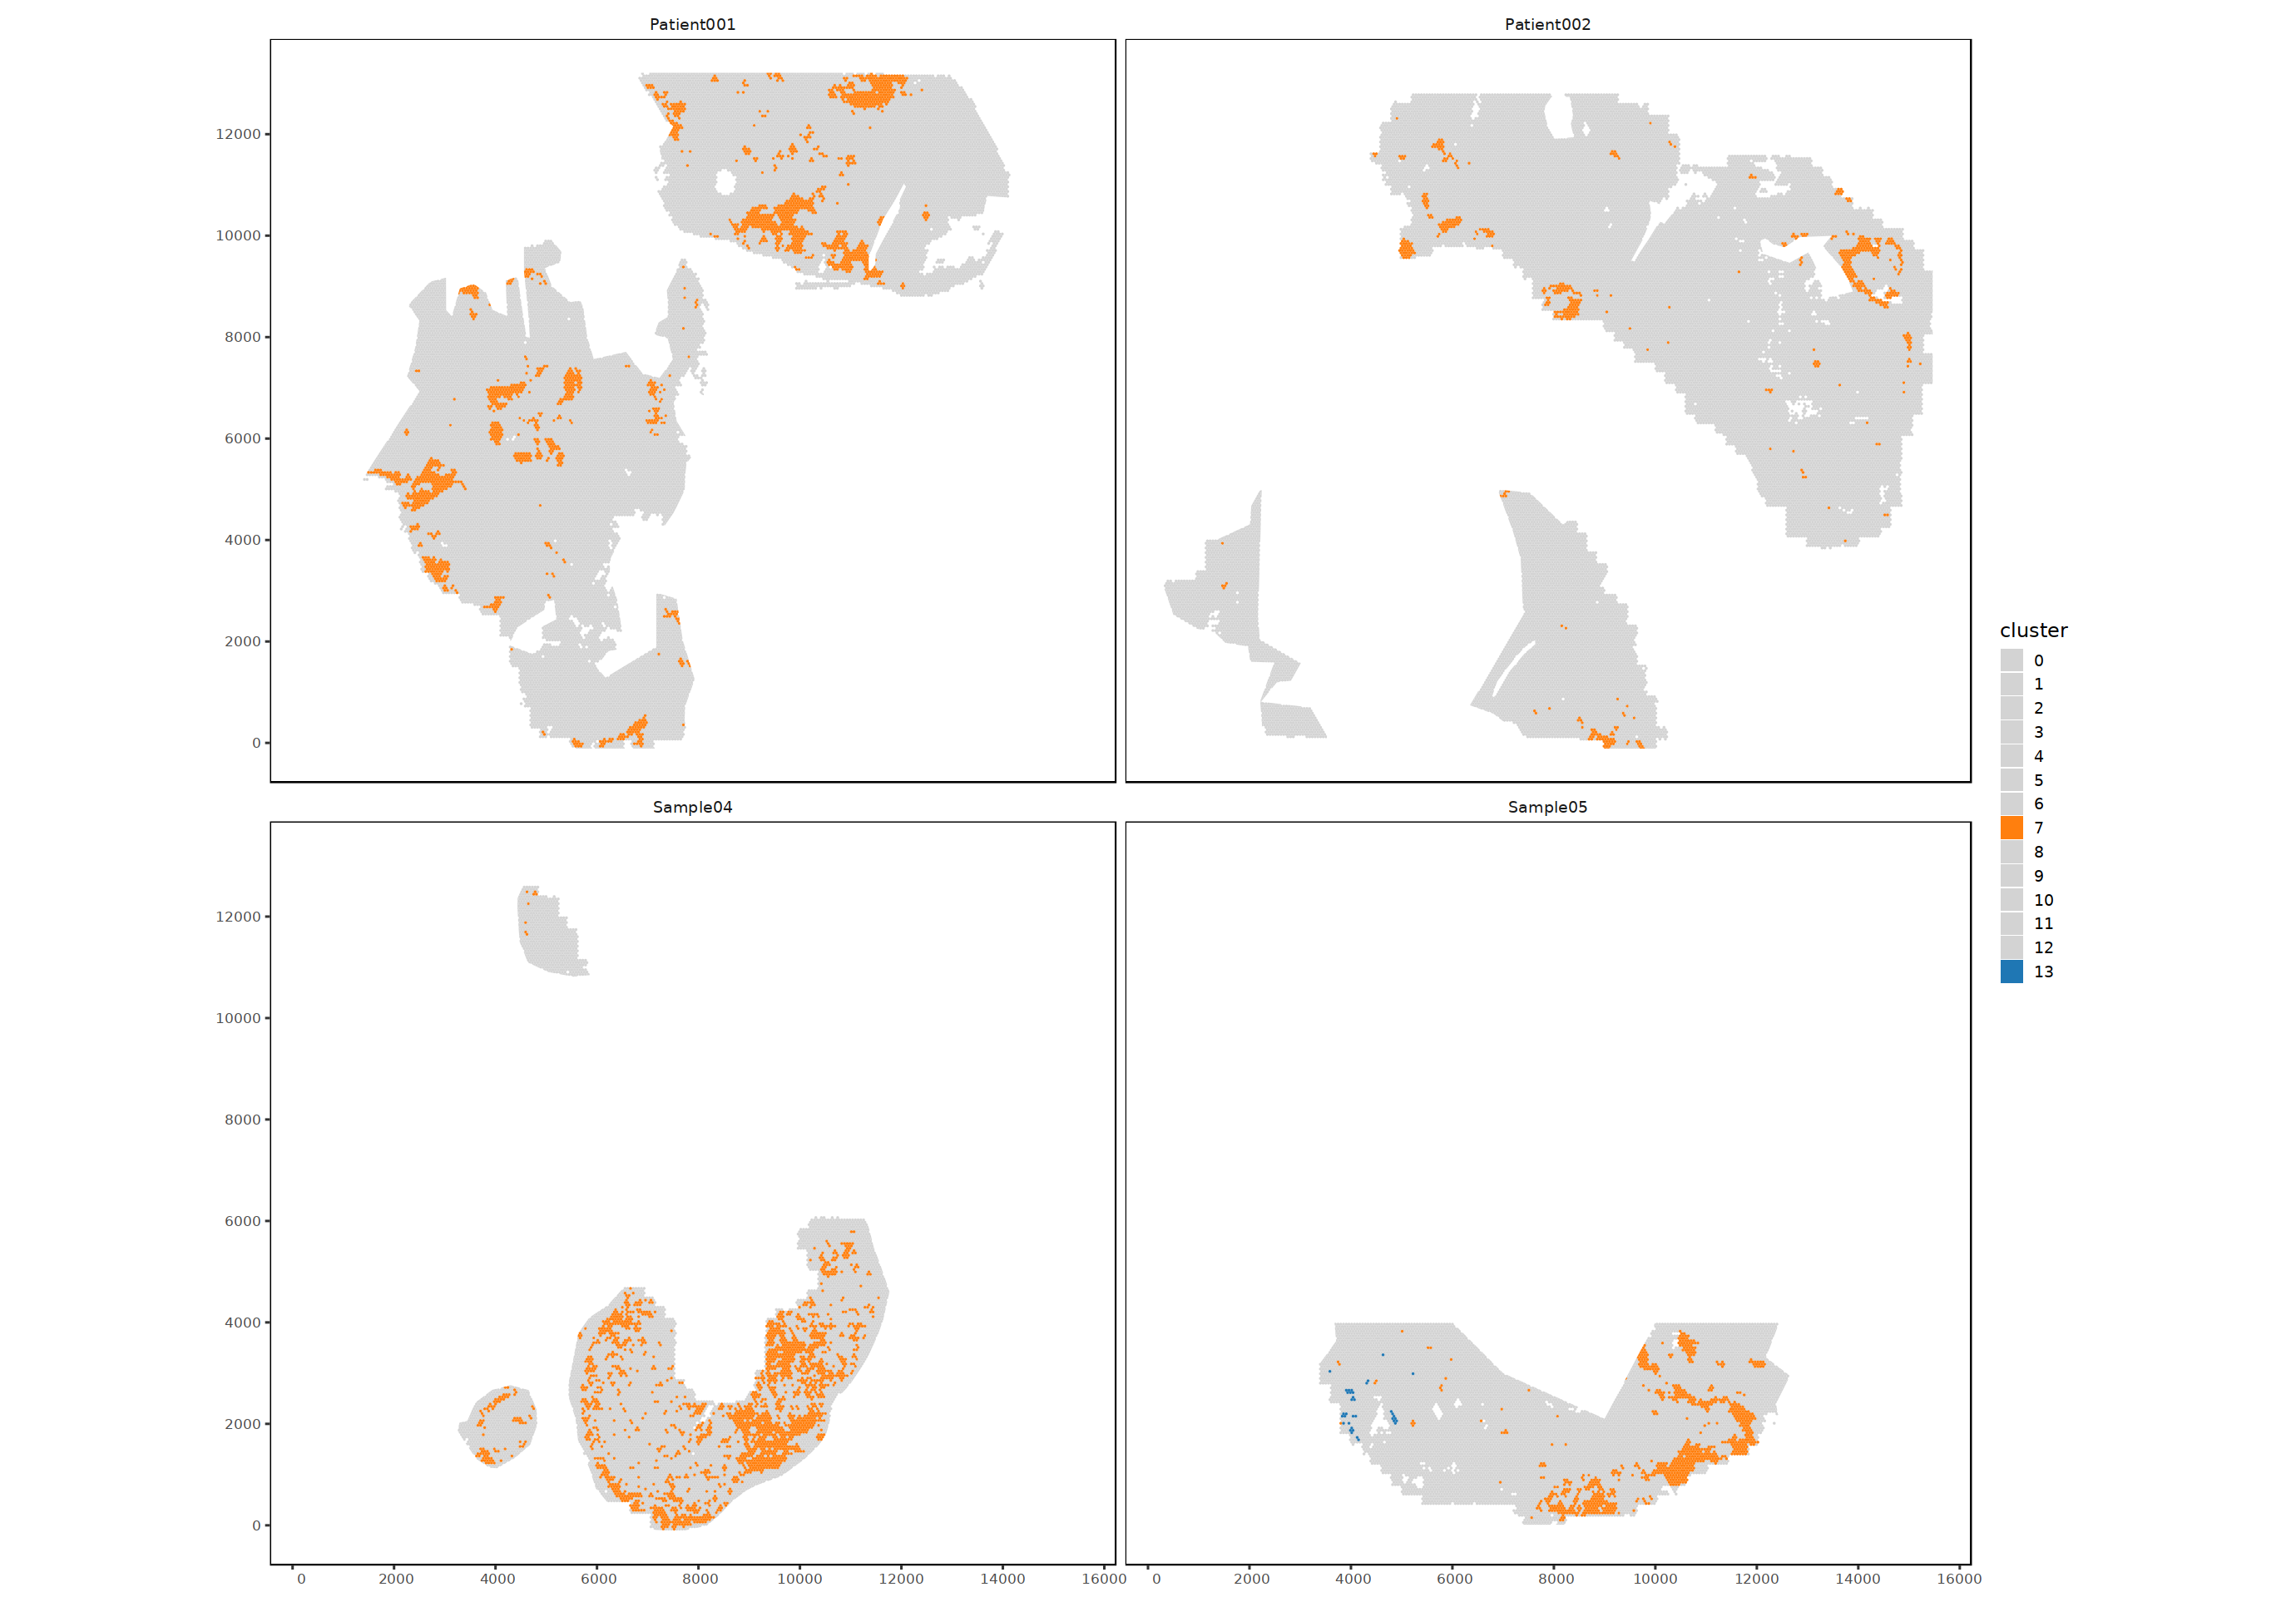

In [102]:
x = levels(meta_data$cluster)
pal <- rep('lightgrey', length(x))
names(pal) <- x
# pal[x %in% c('4', '15', '9')] <- tableau_color_pal('Classic 10')(3)
pal[x %in% c('7', '13')] <- tableau_color_pal('Classic 10')(2)
# pal[x %in% c('4', '12', '2')] <- tableau_color_pal('Classic 10')(3)
# pal[x %in% c('6', '8')] <- tableau_color_pal('Classic 10')(2)
# pal = c(tableau_color_pal('Classic 20')(20), tableau_color_pal('Tableau 10')(10))[1:length(x)]


fig.size(16, 23)
meta_data %>% 
    cbind(tile = shapes) %>% 
    dplyr::mutate(cluster = factor(cluster, 0:30)) %>% 
    ggplot() + 
        geom_sf(aes(geometry = tile, fill = cluster), color = NA) + 
        # scale_fill_tableau('Classic 20') + 
        scale_fill_manual(values = pal) + 
        facet_wrap(~library, nrow = 2) + 
        NULL


### All

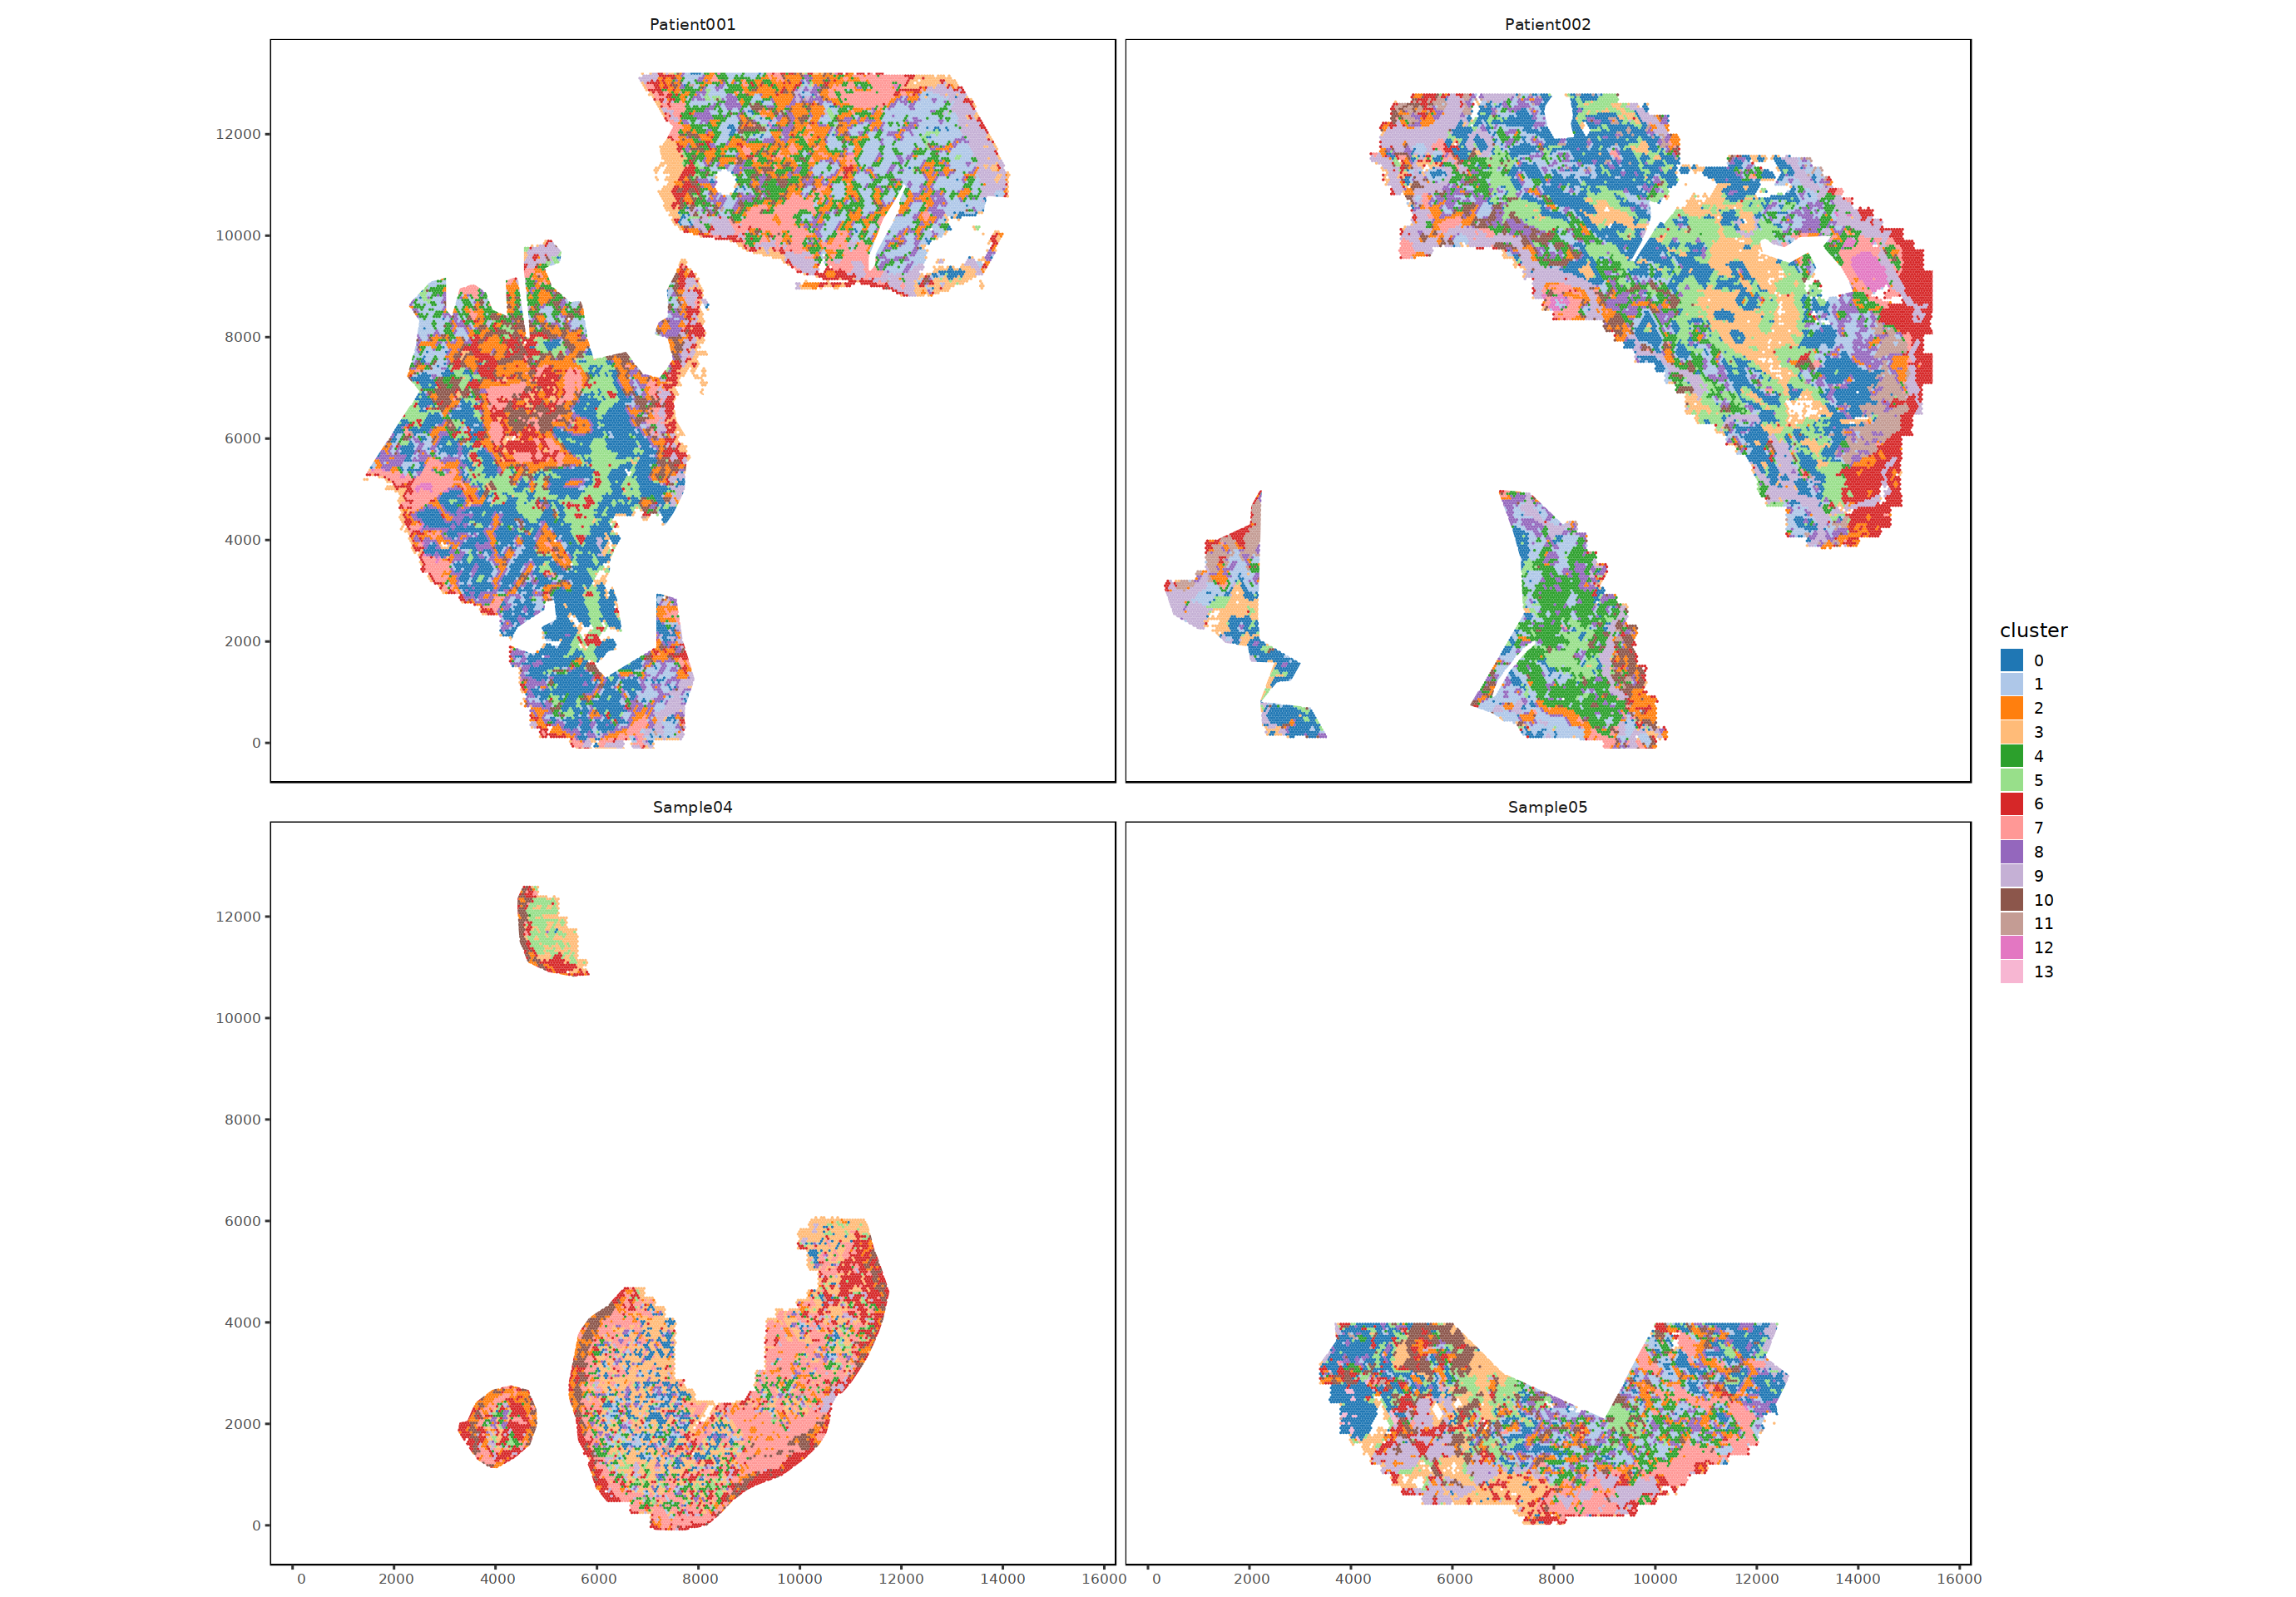

In [114]:
x = levels(meta_data$cluster)
pal <- rep('lightgrey', length(x))
names(pal) <- x
# pal[x %in% c('4', '15', '9')] <- tableau_color_pal('Classic 10')(3)
# pal[x %in% c('4', '10', '11', '9', '0', '8')] <- tableau_color_pal('Classic 10')(6)
# pal[x %in% c('4', '12', '2')] <- tableau_color_pal('Classic 10')(3)
# pal[x %in% c('6', '8')] <- tableau_color_pal('Classic 10')(2)
pal = c(tableau_color_pal('Classic 20')(20), tableau_color_pal('Tableau 10')(10))[1:length(x)]



fig.size(16, 23)
meta_data %>% 
    cbind(tile = shapes) %>% 
    dplyr::mutate(cluster = factor(cluster, 0:30)) %>% 
    ggplot() + 
        geom_sf(aes(geometry = tile, fill = cluster), color = NA) + 
        # scale_fill_tableau('Classic 20') + 
        scale_fill_manual(values = pal) + 
        facet_wrap(~library, nrow = 2) + 
        NULL


In [32]:
# x = levels(clusters$`Clust1.2`)
# pal <- rep('lightgrey', length(x))
# names(pal) <- x
# # pal[x %in% c('4', '15', '9')] <- tableau_color_pal('Classic 10')(3)
# # pal[x %in% c('4', '10', '11', '9', '0', '8', '13')] <- tableau_color_pal('Classic 10')(7)
# # pal[x %in% c('4', '12', '2')] <- tableau_color_pal('Classic 10')(3)
# # pal[x %in% c('6', '8')] <- tableau_color_pal('Classic 10')(2)
# pal = c(tableau_color_pal('Classic 20')(20), tableau_color_pal('Tableau 10')(10))[1:length(x)]



# # fig.size(16, 23)
# # meta_data %>% 
# #     cbind(tile = shapes) %>% 
# #     cbind(clusters) %>% 
# #     dplyr::mutate(Clust1.2 = factor(Clust1.2, 0:30)) %>% 
# #     ggplot() + 
# #         geom_sf(aes(geometry = tile, fill = Clust1.2), color = NA) + 
# #         # scale_fill_tableau('Classic 20') + 
# #         scale_fill_manual(values = pal) + 
# #         facet_wrap(~library, nrow = 2) + 
# #         NULL
# fig.size(16, 23)
# meta_data %>% 
#     cbind(tile = shapes) %>% 
#     cbind(clusters) %>% 
#     subset(library == 'Sample05') %>% 
#     dplyr::mutate(Clust1.2 = factor(Clust1.2, 0:30)) %>% 
#     ggplot() + 
#         geom_sf(aes(geometry = tile, fill = Clust1.2), color = NA) + 
#         # scale_fill_tableau('Classic 20') + 
#         scale_fill_manual(values = pal) + 
#         NULL


### Manual

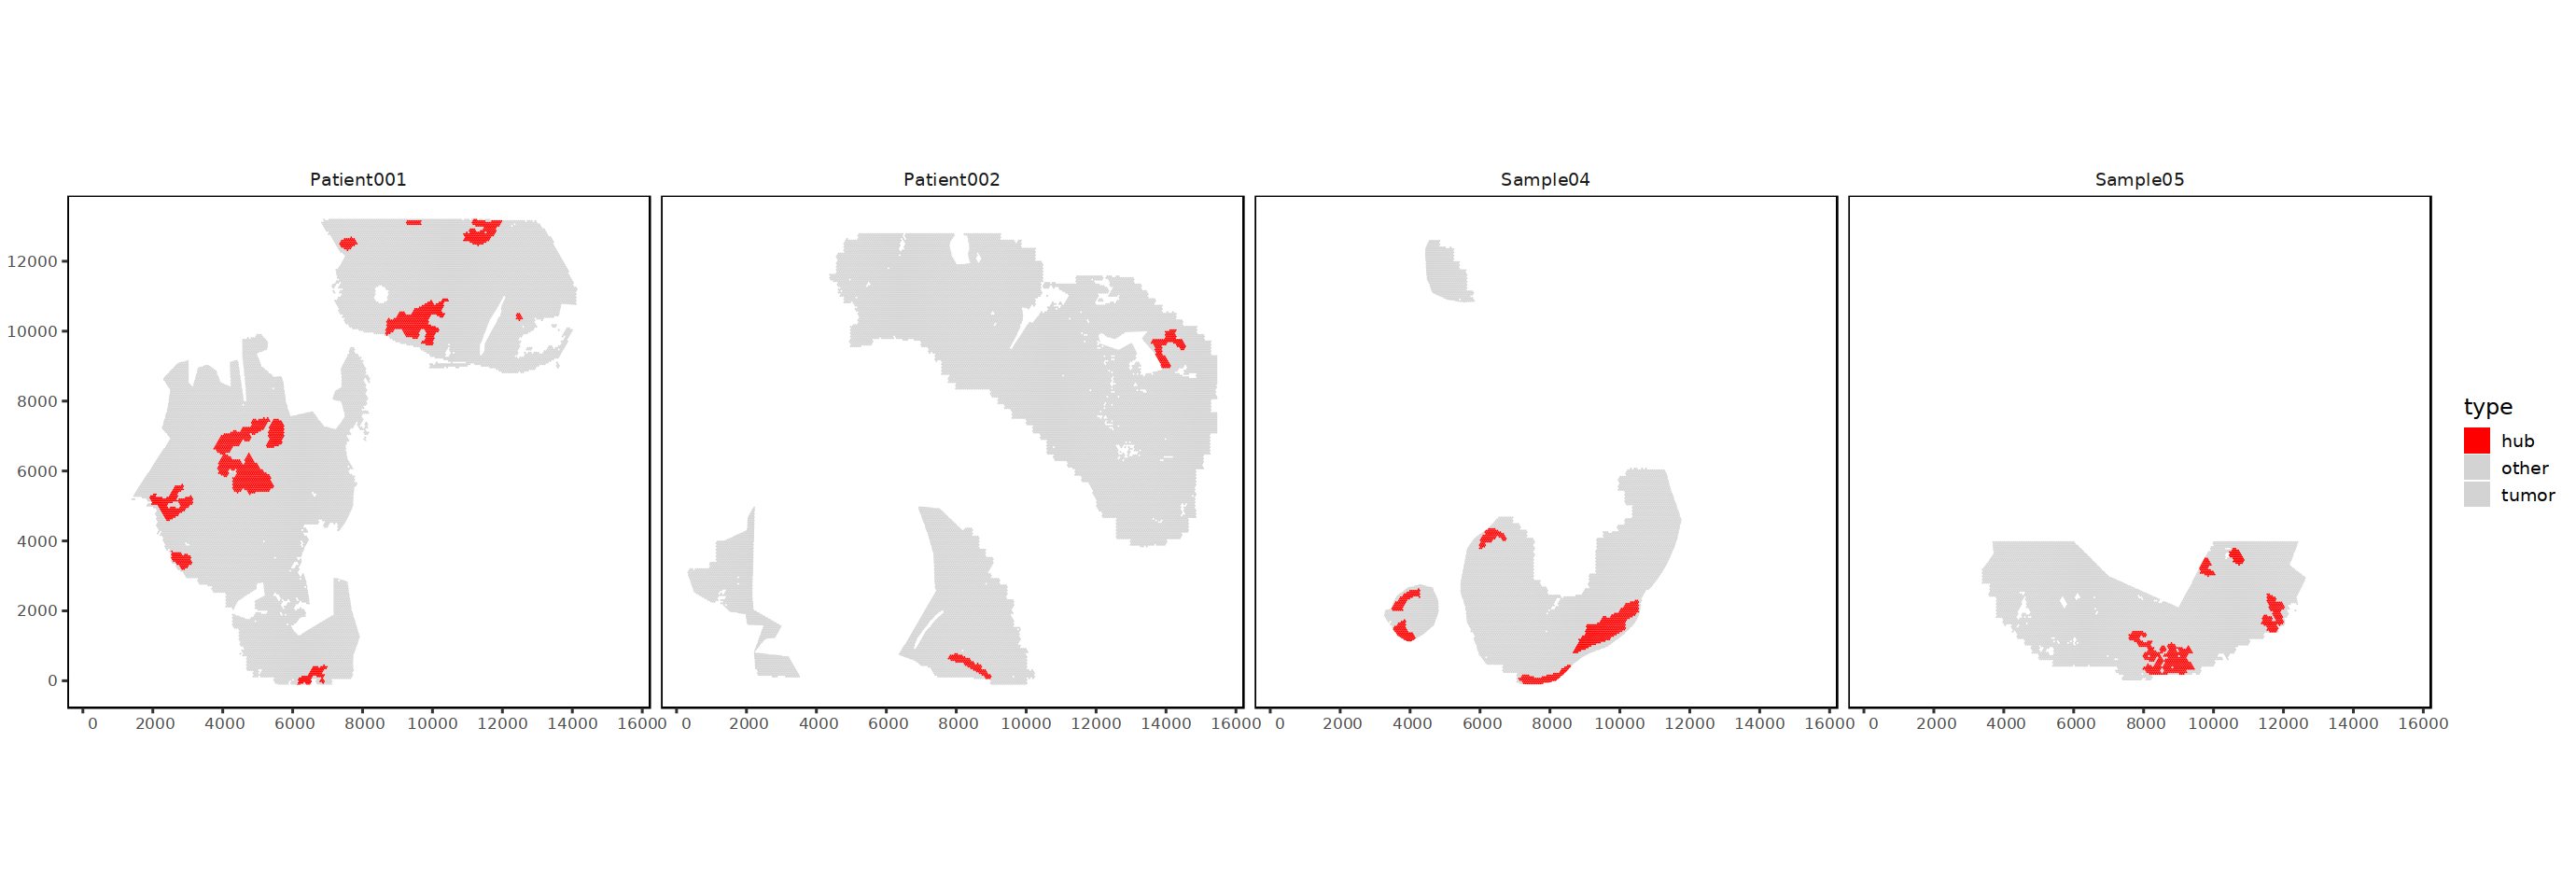

In [39]:
fig.size(8, 23)
meta_data %>% 
    cbind(tile = shapes) %>% 
    cbind(clusters) %>% 
    ggplot() + 
        geom_sf(aes(geometry = tile, fill = type), color = NA) + 
        # scale_fill_tableau('Classic 10') + 
        scale_fill_manual(values = c(hub = 'red', tumor = 'lightgrey', other = 'lightgrey')) + 
        facet_wrap(~library, nrow = 1) + 
        NULL


## Alternative to clustering

In [ ]:
fig.size(4, 16)
meta_data %>% 
    cbind(CCL19 = logcpx['CCL19', ]) %>% 
    cbind(CXCL9_10_11 = apply(logcpx[c('CXCL9', 'CXCL10', 'CXCL11'), ], 2, mean)) %>% 
    # cbind(as.matrix(t(log1p(counts[c('CXCL9', 'CCL19'), ])))) %>% 
    # cbind(as.matrix(t(logcpx[c('CXCL9', 'CCL19'), ]))) %>% 
    # cbind(as.matrix(t(logcpx[c('CXCL9', 'CCL19'), ]))) %>% 
    # cbind(clusters) %>% 
    # subset(library == 'Sample05') %>% 
    ggplot(aes(CXCL9_10_11, CCL19)) + 
        # geom_jitter(height = .05, width = .05, alpha = .2, aes(color = Clust1.2 == '4')) + 
        geom_jitter(height = .05, width = .05, alpha = .2, size = .5, aes(color = type == 'hub')) + 
        scale_color_manual(values = c('lightgrey', 'red')) + 
        labs(title = 'Simple manual gating may recover most of ') + 
        facet_wrap(~library, nrow = 1) + 
        NULL


## Label regions

### Explore markers

In [363]:
## all top markers
effects_marginal %>% 
    subset(fdr < .2 & logFC > 0) %>% 
    # subset(cluster %in% c('C4', 'C7', 'C9')) %>% 
    dplyr::mutate(cluster = factor(cluster, paste0('C', 0:13))) %>% 
    split(.$cluster) %>% 
    map(function(.SD) {
        .SD %>% 
            # dplyr::arrange(-zscore) %>% 
            dplyr::arrange(-logFC) %>% 
            head(10) %>% 
            dplyr::select(feature, cluster) %>% 
            tibble::rowid_to_column('rank')
    }) %>% 
    bind_rows() %>% 
    tidyr::spread(cluster, feature) %>% 
    dplyr::select(-rank) %>% 
    t() %>% 
    identity()

[,1]   [,2]    [,3]   [,4]   [,5]   [,6]     [,7]    [,8]   [,9]   [,10]   
C0  LCN2   MET     RNF43  RORC   OSMR   VEGFA    KRT8    ETV4   TM4SF1 TSPAN13 
C1  MET    ETV4    ANXA1  RNF43  UBE2C  TOP2A    MKI67   KRT8   PTTG1  PCNA    
C2  GJA4   VWF     COL4A1 RGS5   S1PR1  NOTCH4   PDGFRB  SFRP2  SEMA3G NDUFA4L2
C3  FZD1   SPP1    MMP12  PDCD1  IL23R  VEGFA    CCL14   CA12   CMTM2  MMP9    
C4  CXCL10 MARCO   CXCL11 C1QC   C1QB   MSR1     MS4A4A  GBP1   CCR1   CCR5    
C5  SPP1   MMP12   MARCO  VEGFA  CA12   SERPINE1 CXCL8   LAMB3  ITGAX  MSR1    
C6  SPP1   CA1     FOSB   CTSG   LYZ    CD14     PDCD1   GPNMB  C1QA   CD247   
C7  CCR7   MS4A1   SELL   IL7R   CD247  MZB1     CD79A   TCF7   CD27   CCL19   
C8  GJA4   COL4A1  RGS5   PDGFRB ESM1   NOTCH4   CSPG4   CD34   S1PR3  TGFB3   
C9  PDCD1  S100A12 LILRA4 FLI1   CD69   CCL14    TGFBR3  BEST4  REG1A  BMX     
C10 SFRP2  COL10A1 MMP2   MZB1   COL3A1 CD79A    TAGLN   ACTA2  VCAN   COL1A2  
C11 PTTG1  MKI67   TOP2A  ETV4   EPHB3  RORC     UBE2C   CDCA7  PCNA   STMN1   
C12 CD1C   CCL17   CD1E   S100B  RNF43  CKB      CCL19   CSF2RB TNF    BMP2    
C13 MS4A1  CPA3    CD1E   FCER1A CCR7   CXCL1    SIGLEC6 BIRC3  MS4A2  NTRK2

In [364]:
effects_marginal %>% 
    subset(fdr < .2 & logFC > 0) %>% 
    subset(feature %in% c('MET', 'EPCAM', 'TOP2A'))




cluster feature logFC     SD        zscore   pvalue       fdr       
1 C11     TOP2A   0.9234178 0.2937721 3.143313 0.0008352343 0.02000386
2 C1      TOP2A   1.0411837 0.3358665 3.099993 0.0009676273 0.02237555
3 C0      MET     1.2617776 0.4888663 2.581028 0.0049253278 0.07456790
4 C1      MET     1.1891680 0.4904347 2.424722 0.0076600523 0.09993835

In [324]:
immune_clusters <- effects_marginal %>% 
    subset(fdr < .2 & logFC > 0) %>% 
    subset(feature %in% c('PTPRC', 'CD14', 'CPA3', 'CD68', 'CD4', 'CD3E', 'CD8A', 'MARCO', 'C1QC', 'C1QA')) %>% 
    with(cluster)
    # subset(feature %in% c('VWF', 'ACKR1', 'NOTCH4', 'NOTCH3', 'RGS5'))


setdiff(effects_marginal$cluster, immune_clusters)

[1] "C9"  "C12" "C2"  "C3"  "C10" "C7"  "C13" "C6"  "C11" "C5"  "C0"  "C1" 
[13] "C8"  "C4"

In [53]:
tribble(
    ~cluster, ~region_type,
    c('9', '16'), 'hybrid_hub'
)


Clust1.2 region_type
1 9 , 16   hybrid_hub

In [ ]:
foo <- function(g) {
    set.seed(5)
    ht_opt(RESET = TRUE)
    ht_opt("heatmap_column_names_gp" = gpar(fontsize = 10))
    ht_opt("heatmap_row_names_gp" = gpar(fontsize = 10))

    X <- effects_marginal %>% 
        subset(feature %in% g) %>%
        dplyr::select(feature, cluster, SCORE = zscore) %>% 
        # dplyr::select(feature, cluster, SCORE = logFC) %>% 
        tidyr::spread(cluster, SCORE) %>% 
        tibble::column_to_rownames('feature') %>% 
        as.matrix() %>% t()
    plt <- Heatmap(
            X,
            name = 'logFC',
            col = colorRamp2(c(-max(X), 0, max(X)), c('white', 'white', muted('blue')))
            # col = colorRamp2(c(0, .5, 1), c('white', 'white', muted('blue')))
        )

    plt <- grid.grabExpr(draw(plt, padding = unit(c(2, 2, 2, 2), "mm"))) #bottom, left, top, right paddings
    plt_heat <- wrap_elements(plt)
    return(plt_heat)
}

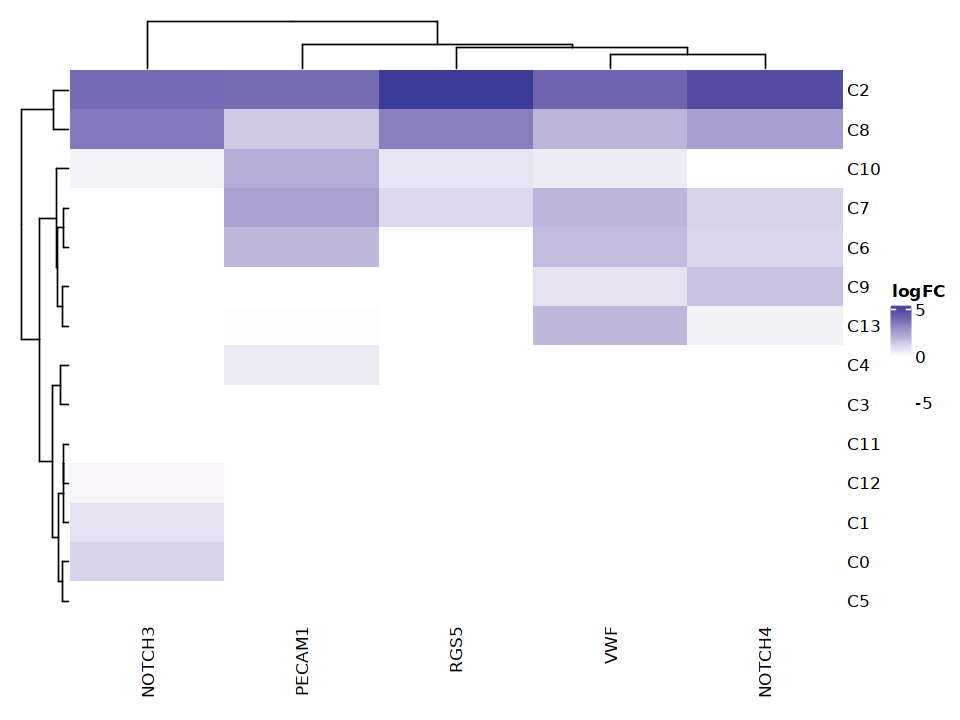

In [323]:
fig.size(6, 8)
# foo(c('CXCL9', 'CXCL10', 'CXCL11', 'CCL19'))
foo(c('VWF', 'NOTCH4', 'NOTCH3', 'RGS5', 'PECAM1'))


### Define them

In [475]:
region_type_dict <- tribble(
    ~cluster, ~region_type,
    c('C0', 'C1', 'C11', 'C12'), 'tumor',
    c('C2', 'C8'), 'vascular',
    c('C4'), 'immune_hub',
    # c('C9'), 'immune_peripheral',
    c('C3', 'C5', 'C6', 'C13', 'C9', 'C10'), 'tumor',
    # c('C3', 'C5', 'C6', 'C13', 'C9', 'C10'), 'immune_other',
    c('C7'), 'hybrid_hub'
    # c('C10'), 'fibro'
) %>% 
    tidyr::unnest(cluster) %>% 
    arrange(cluster)


In [478]:
meta_data <- meta_data %>% 
    dplyr::mutate(cluster = gsub('^C*', '', cluster)) %>%
    dplyr::mutate(cluster = paste0('C', cluster)) %>% 
    left_join(region_type_dict)


Joining, by = "cluster"


In [479]:
head(meta_data)

ID                library  X        Y        ntx type  cluster region_type 
1 tile1723_Sample05 Sample05 3397.185 2802.635  24 other C3      immune_other
2 tile1724_Sample05 Sample05 3397.185 2895.696 155 other C6      immune_other
3 tile1725_Sample05 Sample05 3397.185 2988.756  82 other C0      tumor       
4 tile1726_Sample05 Sample05 3397.185 3081.817 271 other C6      immune_other
5 tile1727_Sample05 Sample05 3397.213 3174.625  74 other C3      immune_other
6 tile1758_Sample05 Sample05 3424.050 2849.165 555 other C2      vascular

### Viz

Ooof - so many of the hubs are labeled immune, but most should be tumor? 

In [480]:
# fig.size(5, 8)
# data.table(hubs)[, area := st_area(shape)][, .(total_area = sum(area)), by = .(region_type, library)] %>% 
#     tidyr::spread(library, total_area, fill = 0) %>% 
#     tibble::column_to_rownames('region_type') %>% 
#     as.matrix() %>% 
#     prop.table(2) %>% 
#     Heatmap()


In [481]:
# fig.size(12, 16)    

# hubs %>% 
#     subset(region_type %in% c('tumor', 'immune_other')) %>% 
#     # subset(region_type %in% c('vascular', 'tumor')) %>% 
#     ggplot() + 
#         geom_sf(
#             aes(fill = region_type),
#             color = NA
#         ) + 
#         scale_fill_tableau('Tableau 10') + 
#         # scale_fill_tableau('Classic 10') + 
#         facet_wrap(~library, nrow = 2) + 
#         NULL


In [482]:
# fig.size(12, 16)    

# hubs %>% 
#     subset(region_type == 'vascular') %>% 
#     ggplot() + 
#         geom_sf(
#             aes(fill = region_type),
#             color = NA
#         ) + 
#         scale_fill_tableau('Tableau 10') + 
#         # scale_fill_tableau('Classic 10') + 
#         facet_wrap(~library, nrow = 2) + 
#         NULL


## Merge adjacent tiles into shapes




### Function

In [6]:
library(igraph)

extract_hubs <- function(.library, .cluster_ids, .min_tiles=5, .dist_buffer=0) {
    df <- meta_data %>% 
        cbind(tile = shapes) %>% 
        subset(library == .library) %>% 
        subset(region_type %in% .cluster_ids)
        # subset(cluster %in% .cluster_ids)

    ## (1) Build neighborhood graph 
    adj <- spatula::getSpatialNeighbors(df[, .(X, Y)], Inf)
    adj_lists <- split(adj@i + 1, rep(1:(length(adj@p)-1), diff(adj@p)))

    ## Remove edge if shapes not touching
    for (i in seq_len(length(adj_lists))) {
        nn_keep <- st_intersects(st_buffer(df$tile[i], .dist_buffer), df$tile[adj_lists[[i]]])[[1]] ## within 100 micron gap
        # nn_keep <- st_touches(df$tile[i], df$tile[adj_lists[[i]]])[[1]] ## must touch exactly 
        nn_keep <- adj_lists[[i]][nn_keep]
        if (length(nn_keep) > 0) {
            adj_lists[[i]] = nn_keep
        } else {
            adj_lists[[i]] = vector(length=0)
        }
    }

    ## (2) Get connected components 
    ## remove small components 
    g = igraph::graph_from_adj_list(adj_lists, 'in')
    g = as.undirected(g) ## this is safer than initializing an undirected graph 
    # g = igraph::graph_from_adj_list(adj_lists, 'all')
    res = components(g, mode = c("weak"))
    res$membership[!res$membership %in% which(res$csize >= .min_tiles)] <- NA
    df$hub <- res$membership

    ## (3) Summarize components into polygons 
    hubs <- df %>% 
        subset(!is.na(hub)) %>% 
        split(.$hub) %>% 
        imap(function(.SD, hub) {
            st_sf(
                ID = hub, 
                ntiles = nrow(.SD), 
                shape = st_sfc(st_union(st_sfc(map(.SD$tile, st_buffer, 0))))
            )
        }) %>% 
        bind_rows() 
    hubs <- cbind(hubs, st_coordinates(st_centroid(hubs)))
    hubs$ID <- as.character(seq_len(nrow(hubs)))
    return(hubs)    
    
}


### Run 

In [7]:
head(meta_data)

ID                library  X        Y        ntx type  cluster region_type 
1 tile1723_Sample05 Sample05 3397.185 2802.635  24 other C3      immune_other
2 tile1724_Sample05 Sample05 3397.185 2895.696 155 other C6      immune_other
3 tile1725_Sample05 Sample05 3397.185 2988.756  82 other C0      tumor       
4 tile1726_Sample05 Sample05 3397.185 3081.817 271 other C6      immune_other
5 tile1727_Sample05 Sample05 3397.213 3174.625  74 other C3      immune_other
6 tile1758_Sample05 Sample05 3424.050 2849.165 555 other C2      vascular

In [471]:
# hubs$cluster <- gsub('^C*', '', hubs$cluster)
# hubs$region_type <- NULL

# hubs <- hubs %>% 
#     data.frame() %>% 
#     dplyr::mutate(cluster = paste0('C', cluster)) %>% 
#     left_join(region_type_dict)

# hubs <- st_as_sf(hubs)

In [9]:
# plan(sequential)
plan(multicore)

hubs <- map(unique(meta_data$library), function(.library) {
    message(.library)
    # future_map('11', function(.cluster) {
    future_map(unique(meta_data$region_type), function(.region_type) {
    # future_map(unique(meta_data$cluster), function(.cluster) {
        message(glue('----{.region_type}'))
        tryCatch({
            suppressWarnings({
                extract_hubs(.library, .region_type, 1, 80) %>% 
                    dplyr::mutate(library = .library, region_type = .region_type)
                # extract_hubs(.library, .cluster, 3, 80) %>% 
                    # dplyr::mutate(library = .library, cluster = .cluster)
            })            
        }, error = function(e) {
            message(glue('Failed on library={.library} region_type={.region_type}'))
            return(NULL)
        }, finally = function(e) {
            return(NULL)
        })
    },
      .options = furrr_options(seed = 42L)  
    ) %>% 
        bind_rows()
})
i <- which(map_int(hubs, nrow) > 0)
hubs <- bind_rows(hubs[i])
hubs$area <- st_area(hubs$shape)
# hubs$cluster <- factor(hubs$cluster, 0:20)


Sample05

----tumor

----vascular

----immune_hub

----hybrid_hub

Patient001

----tumor

----vascular

----immune_hub

----hybrid_hub

Patient002

----tumor

----vascular

----immune_hub

----hybrid_hub

Sample04

----tumor

----vascular

----immune_hub

----hybrid_hub



In [10]:
## Renumber hubIDs in global space
hubs$ID <- as.character(seq_len(nrow(hubs)))

In [11]:
nrow(hubs)
table(hubs$ntiles >= 2)
with(hubs, table(library, region_type))
with(subset(hubs, ntiles >= 2), table(library, region_type))


[1] 1916


FALSE  TRUE 
  708  1208 

            region_type
library      hybrid_hub immune_hub tumor vascular
  Patient001         92        250    80      173
  Patient002         66        176    41      304
  Sample04          110        128    26      211
  Sample05           45         93    15      106

            region_type
library      hybrid_hub immune_hub tumor vascular
  Patient001         60        154    47      129
  Patient002         38        106    24      219
  Sample04           64         67    17      127
  Sample05           22         49     9       76

In [12]:
head(hubs)

Registered S3 method overwritten by 'geojson':
  method        from     
  print.geojson geojsonsf



ID ntiles X         Y         library  region_type
1 1  6381    7156.300 2177.3111 Sample05 tumor      
2 2     1    8286.479  941.4254 Sample05 tumor      
3 3    57   10452.114 2271.2108 Sample05 tumor      
4 4     1   10301.298 2383.8630 Sample05 tumor      
5 5     2   10583.372 1988.3559 Sample05 tumor      
6 6    27   10906.241 1136.1631 Sample05 tumor      
  shape                          area        
1 MULTIPOLYGON (((3800.149 18... 15874262.765
2 POLYGON ((8259.615 925.9153...     2500.000
3 MULTIPOLYGON (((10274.43 22...   142500.018
4 POLYGON ((10274.43 2368.353...     2500.000
5 POLYGON ((10569.94 1980.601...     5000.001
6 POLYGON ((10704.26 1065.506...    67500.009

### Plot hub polygons

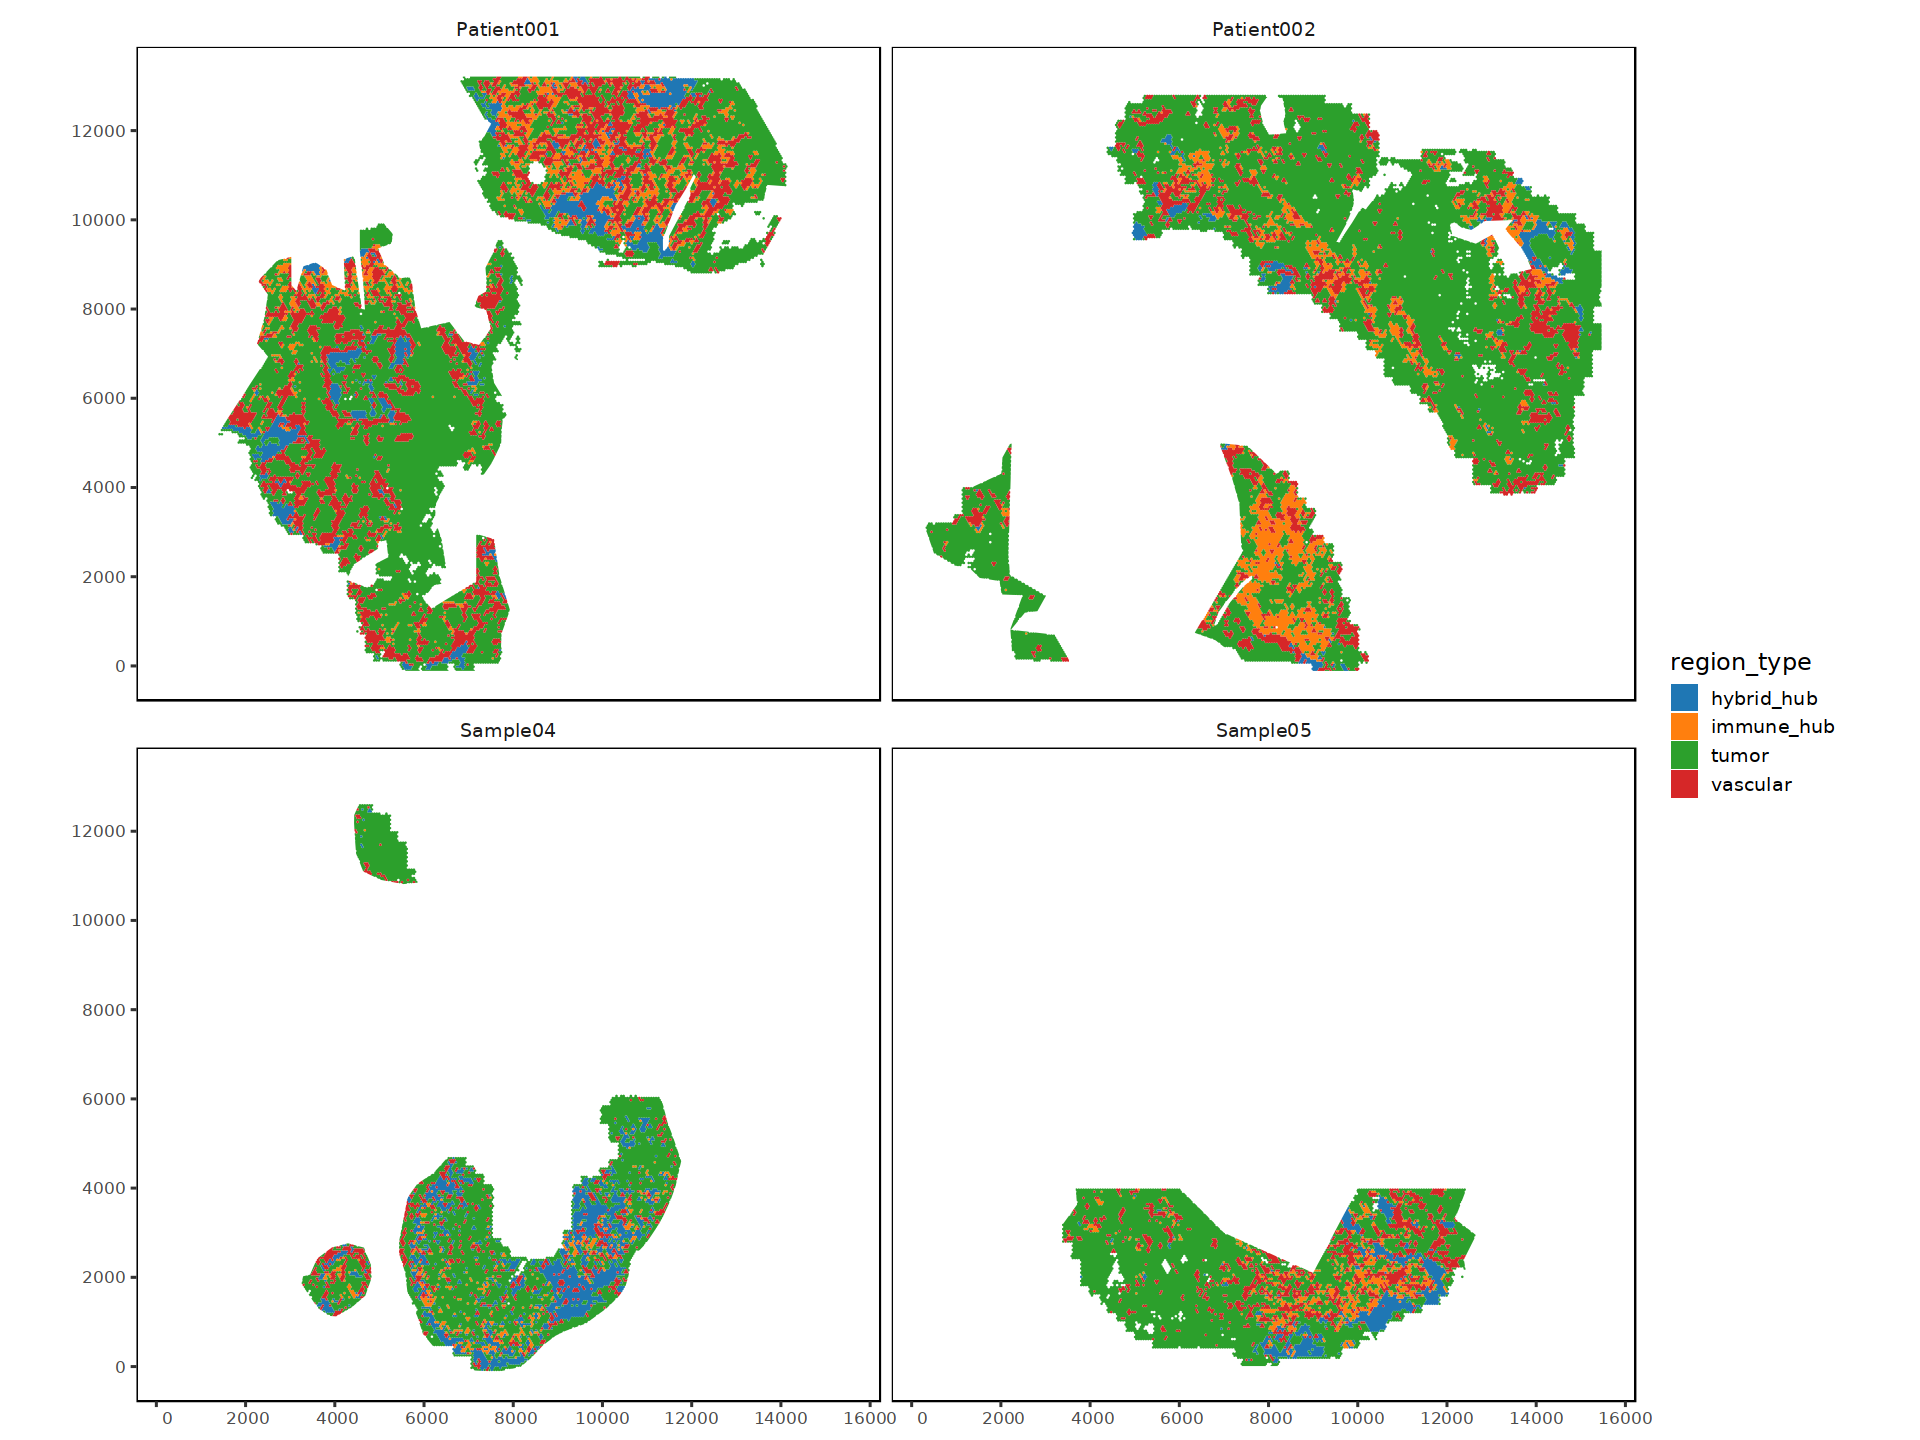

In [15]:
fig.size(12, 16)
hubs %>% 
    ggplot() + 
        geom_sf(
            aes(fill = region_type), 
            color = NA
        ) + 
        scale_fill_tableau('Classic 10') + 
        facet_wrap(~library, nrow = 2) + 
        NULL


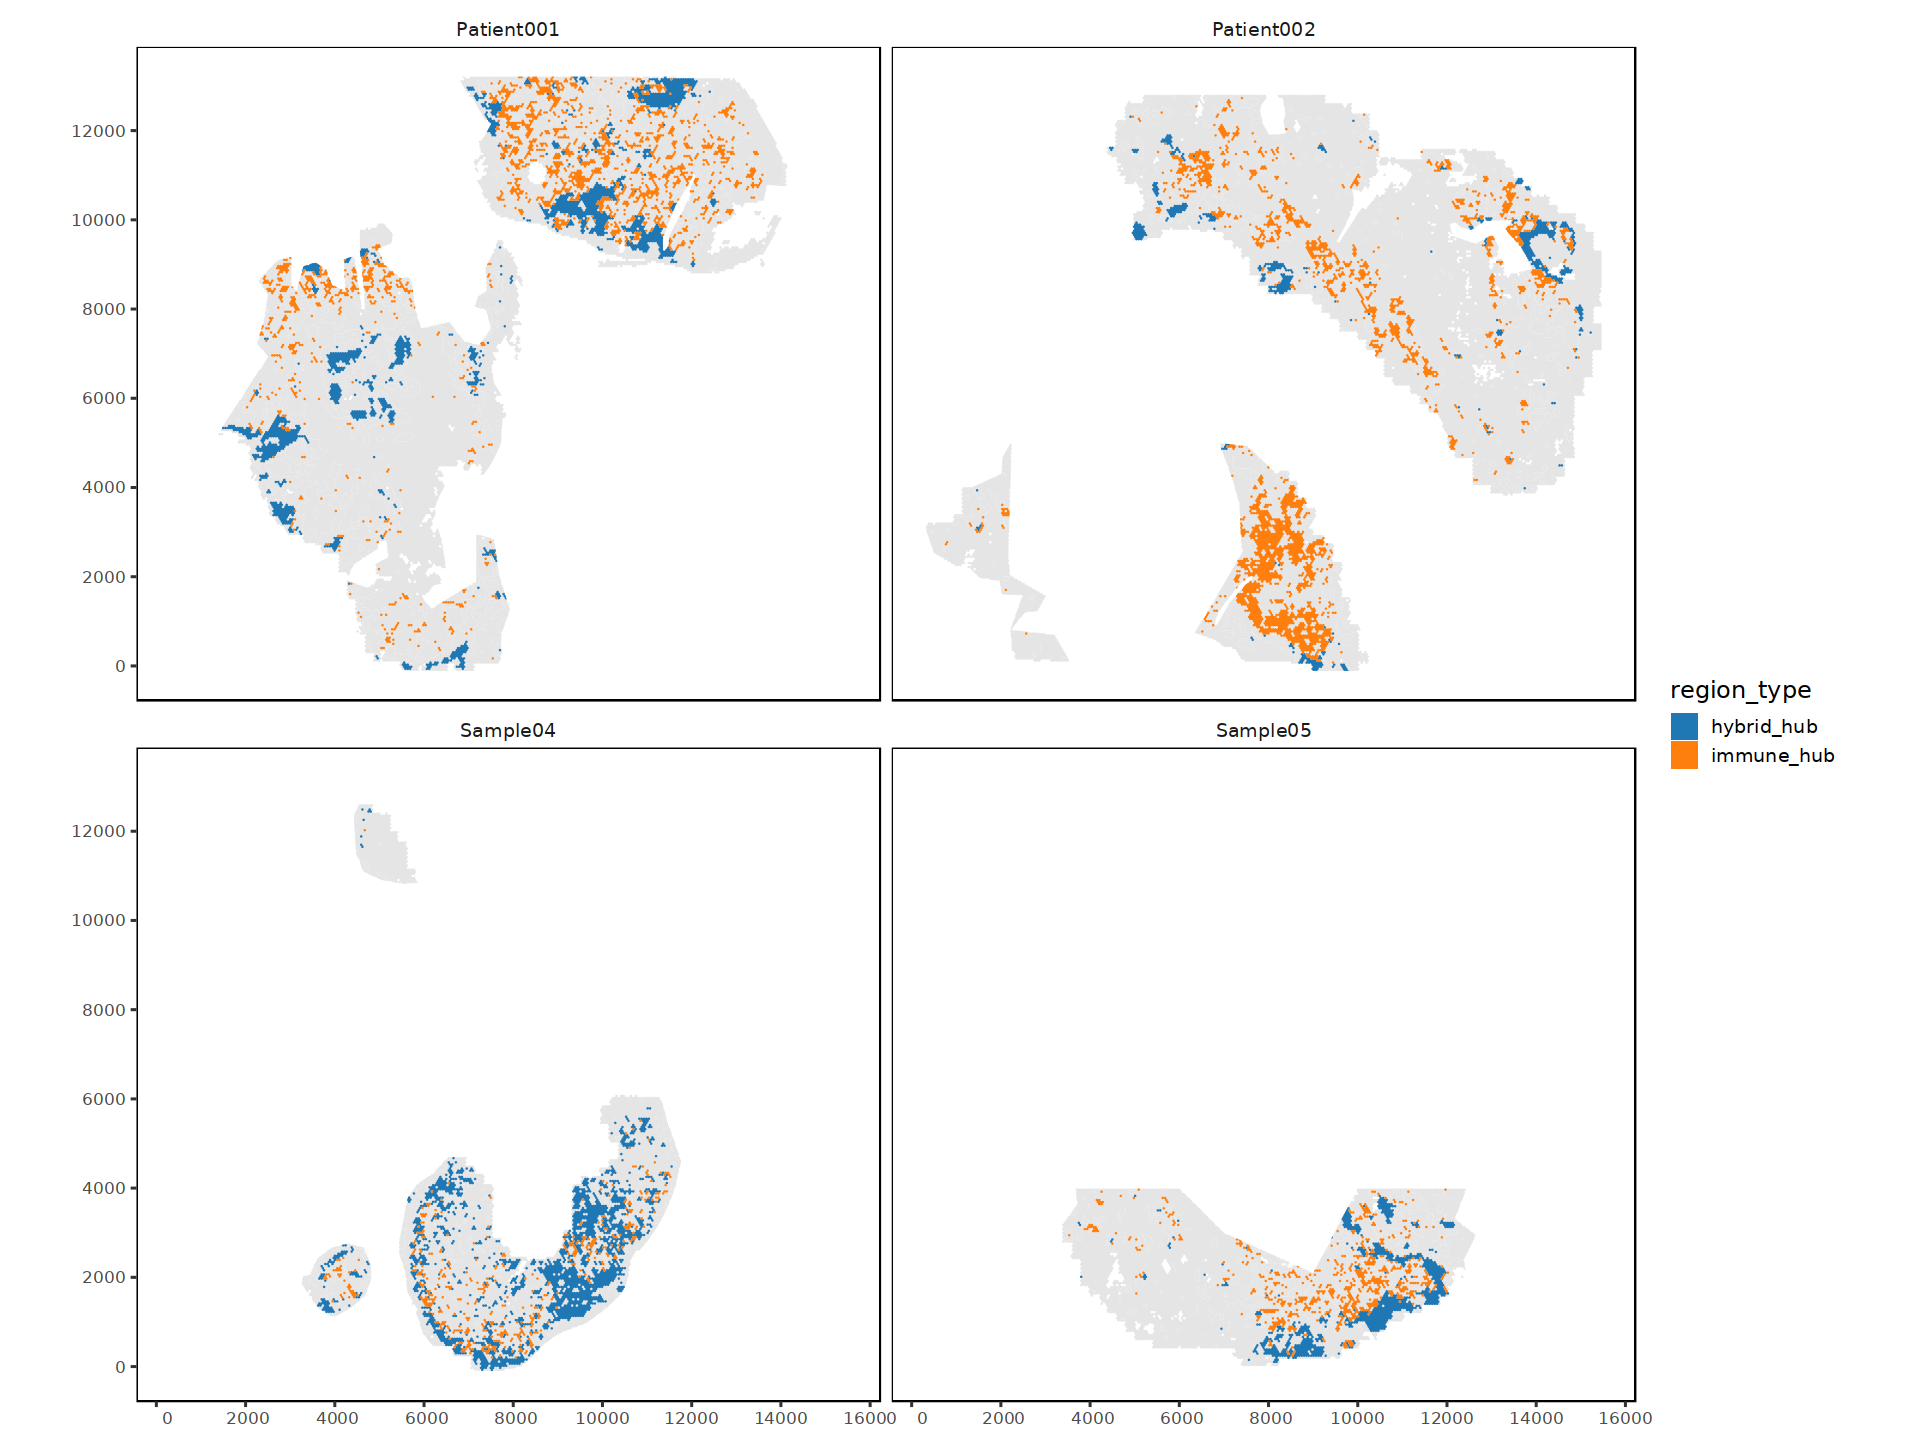

In [16]:
fig.size(12, 16)
hubs %>% 
    ggplot() + 
        geom_sf(color = NA) + 
        geom_sf(
            data = hubs %>% subset(region_type %in% c('hybrid_hub', 'immune_hub')), 
            aes(fill = region_type), 
            color = NA
        ) + 
        scale_fill_tableau('Classic 10') + 
        facet_wrap(~library, nrow = 2) + 
        NULL


### Define region profiles

In [17]:
meta_data = obj$meta_data
meta_data$region_type <- NULL

In [18]:
meta_data_sf <- st_as_sf(cbind(meta_data, shape = shapes))


In [19]:
## Assign hub IDs to tiles 
meta_data <- map(unique(meta_data_sf$library), function(.lib) {
    message(.lib)
    .tiles = subset(meta_data_sf, library == .lib) 
    .hubs = subset(hubs, library == .lib) %>% 
        dplyr::select(hubID = ID, hubType = region_type, hubSize_ntiles = ntiles, hubSize_um2 = area, shape)
    st_join(.tiles, .hubs, largest = TRUE) %>% 
        st_drop_geometry()
}) %>% 
    rbindlist()


Sample05

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Patient001

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Patient002

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Sample04

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [20]:
head(meta_data)

ID                library  X        Y        ntx type  cluster hubID hubType 
1 tile1723_Sample05 Sample05 3397.185 2802.635  24 other C3      1     tumor   
2 tile1724_Sample05 Sample05 3397.185 2895.696 155 other C6      1     tumor   
3 tile1725_Sample05 Sample05 3397.185 2988.756  82 other C0      1     tumor   
4 tile1726_Sample05 Sample05 3397.185 3081.817 271 other C6      1     tumor   
5 tile1727_Sample05 Sample05 3397.213 3174.625  74 other C3      1     tumor   
6 tile1758_Sample05 Sample05 3424.050 2849.165 555 other C2      16    vascular
  hubSize_ntiles hubSize_um2
1 6381           15874263   
2 6381           15874263   
3 6381           15874263   
4 6381           15874263   
5 6381           15874263   
6   15              37500

In [21]:
head(hubs)

ID ntiles X         Y         library  region_type
1 1  6381    7156.300 2177.3111 Sample05 tumor      
2 2     1    8286.479  941.4254 Sample05 tumor      
3 3    57   10452.114 2271.2108 Sample05 tumor      
4 4     1   10301.298 2383.8630 Sample05 tumor      
5 5     2   10583.372 1988.3559 Sample05 tumor      
6 6    27   10906.241 1136.1631 Sample05 tumor      
  shape                          area        
1 MULTIPOLYGON (((3800.149 18... 15874262.765
2 POLYGON ((8259.615 925.9153...     2500.000
3 MULTIPOLYGON (((10274.43 22...   142500.018
4 POLYGON ((10274.43 2368.353...     2500.000
5 POLYGON ((10569.94 1980.601...     5000.001
6 POLYGON ((10704.26 1065.506...    67500.009

In [22]:
hubs_pb <- presto::collapse_counts(counts[, meta_data$ID], meta_data, c('library', 'hubType', 'hubID'))
hubs_pb$exprs_norm = NULL

## Preserve original order
rownames(hubs_pb$meta_data) = hubs_pb$meta_data$hubID
colnames(hubs_pb$counts_mat) = hubs_pb$meta_data$hubID
hubs_pb$meta_data = hubs_pb$meta_data[hubs$ID, ]
hubs_pb$counts_mat = hubs_pb$counts_mat[, hubs_pb$meta_data$hubID]


CAREFUL: get_norm makes very strong assumptions about data



In [23]:
## Sanity checks 
stopifnot(all.equal(nrow(hubs), nrow(hubs_pb$meta_data)))

In [24]:
head(hubs_pb$meta_data)

library  hubType hubID N    logUMI   
1 Sample05 tumor   1     6381 16.467906
2 Sample05 tumor   2        1  8.485290
3 Sample05 tumor   3       57 12.384905
4 Sample05 tumor   4        1  8.270269
5 Sample05 tumor   5        2  8.881420
6 Sample05 tumor   6       27  9.415320

In [25]:
hubs_pb$counts_mat[1:5, 1:5]

1    2 3  4 5
ACE   4131 0 67 1 1
ACKR1 1496 0 10 0 1
ACKR2  808 0 12 0 0
ACKR3 7100 2 49 1 0
ACKR4 1163 0 18 0 0

### Markers on aggregated hubs

In [26]:
library(lme4)
library(future)
library(presto)
library(furrr)


Attaching package: ‘lme4’


The following object is masked from ‘package:nlme’:

    lmList




In [27]:
plan(multicore)
presto_res <- presto.presto(
    y ~ 1 + (1|hubType) + (1|hubType:library) + (1|library) + offset(logUMI), 
    hubs_pb$meta_data, 
    hubs_pb$counts_mat,
    size_varname = 'logUMI', 
    effects_cov = c('hubType'),
    ncore = 20, 
    min_sigma = .05, 
    family = 'poisson',
    nsim = 1000
) 


CAUTION: if using GLMM, make sure your counts are integers!

Warning message:
“Strategy 'multiprocess' is deprecated in future (>= 1.20.0) [2020-10-30]. Instead, explicitly specify either 'multisession' (recommended) or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”
Warning message in rm(.ncore):
“object '.ncore' not found”
Warning message:
“Detected creation of a 'multiprocess' future. Strategy 'multiprocess' is deprecated in future (>= 1.20.0) [2020-10-30]. Instead, explicitly specify either 'multisession' (recommended) or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”
Warning message:
“Detected creation of a 'multiprocess' future. Strategy 'multiprocess' is deprecated in future (>= 1.20.0) [2020-10-30]. Instead, explicitly specify either 'multisession' (recommended) or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”
Warning message:
“Detected creation of a 'multiprocess' future. Strategy 'multiprocess

R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Joining, by = "grpvar_orig"


In [29]:
## did all genes get betas? 
dim(hubs_pb$counts_mat)
dim(presto_res$beta)
any(is.na(presto_res$beta))


[1]  479 1916

[1]  26 479

[1] FALSE

In [30]:
contrasts_mat <- make_contrast.presto(presto_res, "hubType")
markers_hubs <- contrasts.presto(presto_res, contrasts_mat, one_tailed = FALSE) %>% 
    dplyr::mutate(
        logFC = sign(beta) * log2(exp(abs(beta))), 
        SD = log2(exp(sigma))
    ) %>% 
    dplyr::select(hubType = contrast, gene = feature, logFC, SD, zscore, padj = pvalue) %>% 
    arrange(padj)


In [36]:
markers_hubs %>% 
    subset(padj < .2) %>% 
    split(.$hubType) %>% 
    map(dplyr::arrange, -logFC) %>% 
    map(head, 10)

$hybrid_hub
# A tibble: 10 × 6
   hubType    gene  logFC    SD zscore          padj
   <chr>      <chr> <dbl> <dbl>  <dbl>         <dbl>
 1 hybrid_hub CCR7   2.61 0.562   4.64 0.00000342   
 2 hybrid_hub MS4A1  2.52 0.784   3.21 0.00133      
 3 hybrid_hub TCF7   2.12 0.561   3.79 0.000152     
 4 hybrid_hub CCL19  2.11 0.445   4.73 0.00000227   
 5 hybrid_hub SELL   2.02 0.537   3.75 0.000176     
 6 hybrid_hub CXCR5  2.00 0.344   5.81 0.00000000615
 7 hybrid_hub CD247  2.00 0.396   5.04 0.000000469  
 8 hybrid_hub IL7R   1.97 0.532   3.71 0.000205     
 9 hybrid_hub CCL17  1.78 0.307   5.79 0.00000000699
10 hybrid_hub CD19   1.72 0.503   3.42 0.000616     

$immune_hub
# A tibble: 10 × 6
   hubType    gene   logFC     SD zscore        padj
   <chr>      <chr>  <dbl>  <dbl>  <dbl>       <dbl>
 1 immune_hub MARCO  0.878 0.214    4.10 0.0000416  
 2 immune_hub CXCL10 0.611 0.282    2.17 0.0302     
 3 immune_hub C1QB   0.569 0.144    3.94 0.0000802  
 4 immune_hub C1QC   0.564 0.143    3.94 0.0000827  
 5 immune_hub MSR1   0.560 0.144    3.89 0.000102   
 6 immune_hub C1QA   0.476 0.137    3.47 0.000526   
 7 immune_hub FCGR3A 0.439 0.116    3.79 0.000150   
 8 immune_hub TSPAN6 0.415 0.131    3.17 0.00153    
 9 immune_hub AIF1   0.413 0.0812   5.09 0.000000362
10 immune_hub MS4A4A 0.386 0.145    2.65 0.00800    

$tumor
# A tibble: 10 × 6
   hubType gene  logFC    SD zscore   padj
   <chr>   <chr> <dbl> <dbl>  <dbl>  <dbl>
 1 tumor   SPP1  1.58  0.846   1.86 0.0624
 2 tumor   LCN2  1.15  0.675   1.71 0.0870
 3 tumor   VEGFA 1.15  0.505   2.28 0.0228
 4 tumor   RNF43 1.07  0.539   1.98 0.0478
 5 tumor   MET   0.988 0.547   1.81 0.0705
 6 tumor   RORC  0.985 0.435   2.27 0.0235
 7 tumor   ETV4  0.890 0.563   1.58 0.114 
 8 tumor   OSMR  0.860 0.465   1.85 0.0643
 9 tumor   MMP12 0.849 0.438   1.94 0.0526
10 tumor   CKB   0.842 0.487   1.73 0.0837

$vascular
# A tibble: 10 × 6
   hubType  gene   logFC    SD zscore     padj
   <chr>    <chr>  <dbl> <dbl>  <dbl>    <dbl>
 1 vascular GJA4    2.12 0.538   3.94 8.27e- 5
 2 vascular VWF     1.87 0.664   2.82 4.84e- 3
 3 vascular RGS5    1.69 0.691   2.44 1.45e- 2
 4 vascular COL4A1  1.63 0.426   3.82 1.34e- 4
 5 vascular ESM1    1.59 0.245   6.48 8.97e-11
 6 vascular DLL4    1.57 0.445   3.53 4.14e- 4
 7 vascular NOTCH4  1.56 0.664   2.34 1.91e- 2
 8 vascular CSPG4   1.41 0.291   4.84 1.33e- 6
 9 vascular SEMA3G  1.39 0.757   1.84 6.65e- 2
10 vascular S1PR1   1.34 0.662   2.03 4.23e- 2

## Total covered areas 

In [20]:
# regions_total <- hubs %>% 
#     data.table() %>% 
#     split(.$library) %>% 
#     imap(function(.SD, .library) {
#         st_sf(
#             library = .library, 
#             shape = st_union(.SD[, shape][])
#         )
#     }) %>% 
#     bind_rows()

# nrow(regions_total)

# regions_total %>%
#     ggplot() + 
#         geom_sf(color = NA) + 
#         facet_wrap(~library, nrow = 1)



In [21]:
# regions_by_type <- hubs %>% 
#     data.table() %>% 
#     split(paste(.$library, .$region_type)) %>% 
#     imap(function(.SD, .library_region) {
#         st_sf(
#             library = gsub('(.*) (.*)', '\\1', .library_region),
#             region_type = gsub('(.*) (.*)', '\\2', .library_region),
#             shape = st_union(.SD[, shape][])
#         )
#     }) %>% 
#     bind_rows()


# nrow(regions_by_type)

# regions_by_type %>%
#     ggplot() + 
#         geom_sf(color = NA, aes(fill = region_type)) + 
#         scale_fill_tableau() + 
#         facet_wrap(~library, nrow = 1)


## Cache

In [55]:
## tiles object 
obj <- list(
    clusters = clusters,
    counts = counts,
    normalization_factor = median(colSums(counts)), ## instead of saving logcpx 
    # logcpx = logcpx, ## no need to save it 
    markers_clusters = effects_marginal,
    markers_hubs = markers_hubs, 
    meta_data = meta_data,
    pca_res = pca_res,
    U = U, ## from PCA
    U2 = U2, ## from Harmony
    Z_corr = Z_corr,
    Z_cos = Z_cos, 
    R = R,
    shapes = shapes
)

saveRDS(obj, 'lung_n4/grid/obj.rds')
# st_write_parquet(regions_by_type, 'lung_n4/grid/regions_by_type.parquet')
# st_write_parquet(regions_total, 'lung_n4/grid/regions_total.parquet')


In [ ]:
# st_write_parquet(hubs, 'lung_n4/grid/hubs.parquet')


In [59]:
hubs$logUMI = hubs_pb$meta_data$logUMI
list(
    meta_data = dplyr::select(hubs, library, hubType = region_type, ID, ntiles, X, Y, area, shape), 
    counts = hubs_pb$counts_mat
) %>% 
    saveRDS('lung_n4/grid/obj_hubs.rds')


In [3]:
obj = readRDS('lung_n4/grid/obj.rds')
clusters = obj$clusters
counts = obj$counts
logcpx = obj$logcpx
meta_data = obj$meta_data
pca_res = obj$pca_res
U = obj$U
U2 = obj$U2
# markers = obj$markers
Z_corr = obj$Z_corr
Z_cos = obj$Z_cos
R = obj$R
shapes <- st_read_parquet('lung_n4/grid/shapes.parquet')$tile
hubs <- st_read_parquet('lung_n4/grid/hubs.parquet')


In [4]:
# hubs$region_type[which(hubs$region_type == 'immune_other')] = 'tumor'
# meta_data$region_type[which(meta_data$region_type == 'immune_other')] = 'tumor'

In [5]:
head(meta_data)

ID                library  X        Y        ntx type  cluster hubID hubType 
1 tile1723_Sample05 Sample05 3397.185 2802.635  24 other C3      1     tumor   
2 tile1724_Sample05 Sample05 3397.185 2895.696 155 other C6      1     tumor   
3 tile1725_Sample05 Sample05 3397.185 2988.756  82 other C0      1     tumor   
4 tile1726_Sample05 Sample05 3397.185 3081.817 271 other C6      1     tumor   
5 tile1727_Sample05 Sample05 3397.213 3174.625  74 other C3      1     tumor   
6 tile1758_Sample05 Sample05 3424.050 2849.165 555 other C2      16    vascular
  hubSize_ntiles hubSize_um2
1 6381           15874263   
2 6381           15874263   
3 6381           15874263   
4 6381           15874263   
5 6381           15874263   
6   15              37500

# Figures

## Tile-level hub markers

In [7]:
library(lme4)
library(future)
library(presto)
library(furrr)

In [9]:
names(obj)

[1] "clusters"             "counts"               "normalization_factor"
 [4] "markers_clusters"     "markers_hubs"         "meta_data"           
 [7] "pca_res"              "U"                    "U2"                  
[10] "Z_corr"               "Z_cos"                "R"                   
[13] "shapes"

In [12]:
head(obj$meta_data)

ID                library  X        Y        ntx type  cluster hubID hubType 
1 tile1723_Sample05 Sample05 3397.185 2802.635  24 other C3      1     tumor   
2 tile1724_Sample05 Sample05 3397.185 2895.696 155 other C6      1     tumor   
3 tile1725_Sample05 Sample05 3397.185 2988.756  82 other C0      1     tumor   
4 tile1726_Sample05 Sample05 3397.185 3081.817 271 other C6      1     tumor   
5 tile1727_Sample05 Sample05 3397.213 3174.625  74 other C3      1     tumor   
6 tile1758_Sample05 Sample05 3424.050 2849.165 555 other C2      16    vascular
  hubSize_ntiles hubSize_um2
1 6381           15874263   
2 6381           15874263   
3 6381           15874263   
4 6381           15874263   
5 6381           15874263   
6   15              37500

In [15]:
obj$meta_data$logUMI = log(obj$meta_data$ntx)

In [16]:
plan(multicore)
system.time({
    presto_res <- presto.presto(
        y ~ 1 + (1|hubType) + (1|hubType:library) + (1|library) + offset(logUMI), 
        obj$meta_data, 
        obj$counts, 
        # hubs_pb$meta_data, 
        # hubs_pb$counts_mat,
        size_varname = 'logUMI', 
        effects_cov = c('hubType'),
        ncore = 20, 
        min_sigma = .05, 
        family = 'poisson',
        nsim = 1000
    )     
})


CAUTION: if using GLMM, make sure your counts are integers!

Warning message:
“Strategy 'multiprocess' is deprecated in future (>= 1.20.0) [2020-10-30]. Instead, explicitly specify either 'multisession' (recommended) or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”
Warning message in rm(.ncore):
“object '.ncore' not found”
Warning message:
“Detected creation of a 'multiprocess' future. Strategy 'multiprocess' is deprecated in future (>= 1.20.0) [2020-10-30]. Instead, explicitly specify either 'multisession' (recommended) or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”
Warning message:
“Detected creation of a 'multiprocess' future. Strategy 'multiprocess' is deprecated in future (>= 1.20.0) [2020-10-30]. Instead, explicitly specify either 'multisession' (recommended) or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”
Warning message:
“Detected creation of a 'multiprocess' future. Strategy 'multiprocess

R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Joining, by = "grpvar_orig"


     user    system   elapsed 
27774.643 35238.882  3215.504 

In [20]:
contrasts_mat <- make_contrast.presto(presto_res, "hubType")
markers_tiles <- contrasts.presto(presto_res, contrasts_mat, one_tailed = FALSE) %>% 
    dplyr::mutate(
        logFC = sign(beta) * log2(exp(abs(beta))), 
        SD = log2(exp(sigma))
    ) %>% 
    dplyr::select(hubType = contrast, gene = feature, logFC, SD, zscore, padj = pvalue) %>% 
    arrange(padj)


In [21]:
markers_tiles %>% 
    subset(padj < .2) %>% 
    split(.$hubType) %>% 
    map(dplyr::arrange, -logFC) %>% 
    map(head, 10)

$hybrid_hub
# A tibble: 10 × 6
   hubType    gene  logFC    SD zscore          padj
   <chr>      <chr> <dbl> <dbl>  <dbl>         <dbl>
 1 hybrid_hub CCR7   2.61 0.576   4.53 0.00000585   
 2 hybrid_hub MS4A1  2.51 0.812   3.10 0.00195      
 3 hybrid_hub TCF7   2.12 0.562   3.77 0.000162     
 4 hybrid_hub CCL19  2.10 0.430   4.89 0.00000100   
 5 hybrid_hub SELL   2.01 0.526   3.83 0.000129     
 6 hybrid_hub CXCR5  2.00 0.338   5.91 0.00000000351
 7 hybrid_hub CD247  2.00 0.422   4.73 0.00000223   
 8 hybrid_hub IL7R   1.97 0.540   3.66 0.000256     
 9 hybrid_hub CCL17  1.78 0.315   5.64 0.0000000172 
10 hybrid_hub CD19   1.72 0.477   3.61 0.000310     

$immune_hub
# A tibble: 10 × 6
   hubType    gene   logFC     SD zscore       padj
   <chr>      <chr>  <dbl>  <dbl>  <dbl>      <dbl>
 1 immune_hub MARCO  0.873 0.216    4.05 0.0000512 
 2 immune_hub CXCL10 0.608 0.280    2.17 0.0300    
 3 immune_hub C1QB   0.563 0.145    3.89 0.000101  
 4 immune_hub C1QC   0.559 0.146    3.82 0.000135  
 5 immune_hub MSR1   0.554 0.146    3.79 0.000152  
 6 immune_hub C1QA   0.471 0.134    3.51 0.000456  
 7 immune_hub FCGR3A 0.434 0.114    3.82 0.000135  
 8 immune_hub TSPAN6 0.413 0.135    3.06 0.00223   
 9 immune_hub AIF1   0.409 0.0869   4.71 0.00000252
10 immune_hub MS4A4A 0.380 0.149    2.55 0.0109    

$tumor
# A tibble: 10 × 6
   hubType gene  logFC    SD zscore   padj
   <chr>   <chr> <dbl> <dbl>  <dbl>  <dbl>
 1 tumor   SPP1  1.58  0.810   1.94 0.0518
 2 tumor   LCN2  1.16  0.715   1.62 0.106 
 3 tumor   VEGFA 1.15  0.497   2.32 0.0206
 4 tumor   RNF43 1.07  0.524   2.04 0.0417
 5 tumor   MET   0.989 0.522   1.89 0.0583
 6 tumor   RORC  0.986 0.428   2.30 0.0212
 7 tumor   ETV4  0.891 0.544   1.64 0.102 
 8 tumor   OSMR  0.860 0.451   1.91 0.0566
 9 tumor   MMP12 0.846 0.438   1.93 0.0534
10 tumor   CKB   0.841 0.509   1.65 0.0986

$vascular
# A tibble: 10 × 6
   hubType  gene   logFC    SD zscore     padj
   <chr>    <chr>  <dbl> <dbl>  <dbl>    <dbl>
 1 vascular GJA4    2.12 0.552   3.85 1.18e- 4
 2 vascular VWF     1.88 0.637   2.95 3.20e- 3
 3 vascular RGS5    1.69 0.708   2.39 1.66e- 2
 4 vascular COL4A1  1.63 0.448   3.64 2.73e- 4
 5 vascular ESM1    1.59 0.240   6.64 3.22e-11
 6 vascular DLL4    1.57 0.457   3.44 5.78e- 4
 7 vascular NOTCH4  1.56 0.659   2.37 1.78e- 2
 8 vascular CSPG4   1.41 0.277   5.10 3.37e- 7
 9 vascular SEMA3G  1.39 0.765   1.82 6.86e- 2
10 vascular S1PR1   1.35 0.661   2.04 4.14e- 2

In [22]:
fwrite(markers_tiles, 'tables/tile_markers.csv')

## EXTRA: cluster-level markers

In [3]:
tiles = list(
    meta_data = fread('share/tiles/meta_data.csv'), 
    markers_clusters = fread('share/tiles/markers_clusters.csv'), 
    shapes = sfarrow::st_read_parquet('share/tiles/shapes.parquet')$shape
)

In [9]:
x = fread('share/tiles/markers_clusters.csv')
x$cluster = gsub('^C*', 'C', x$cluster)

In [10]:
head(x)

cluster feature  logFC    SD        zscore   pvalue       fdr         
1 C9      REG1A    1.718721 0.2639909 6.510531 3.744289e-11 1.690070e-07
2 C9      S100A12  1.932807 0.2989310 6.465732 5.040471e-11 1.690070e-07
3 C9      CCL14    1.796322 0.2847412 6.308613 1.407739e-10 3.146766e-07
4 C9      LILRA4   1.931496 0.3087473 6.255911 1.976009e-10 3.312779e-07
5 C9      TNFSF13B 1.465151 0.2437476 6.010937 9.222688e-10 1.236947e-06
6 C9      BEST4    1.754623 0.2964877 5.918030 1.629102e-09 1.818088e-06

In [19]:
x[cluster == 'C7'][order(-logFC)][, rank_by_logFC := 1:.N][feature %in% paste0('CXCL', 9:11)]
x[cluster == 'C7'][order(-zscore)][, rank_by_zscore := 1:.N][feature %in% paste0('CXCL', 9:11)]


cluster feature logFC     SD        zscore   pvalue       fdr         
1 C7      CXCL9   1.3640794 0.3042541 4.483356 3.673903e-06 0.0005027999
2 C7      CXCL10  0.8842917 0.2246827 3.935736 4.147110e-05 0.0022248416
3 C7      CXCL11  0.8357100 0.2831625 2.951345 1.581968e-03 0.0325974043
  rank_by_logFC
1 31           
2 66           
3 73

cluster feature logFC     SD        zscore   pvalue       fdr         
1 C7      CXCL9   1.3640794 0.3042541 4.483356 3.673903e-06 0.0005027999
2 C7      CXCL10  0.8842917 0.2246827 3.935736 4.147110e-05 0.0022248416
3 C7      CXCL11  0.8357100 0.2831625 2.951345 1.581968e-03 0.0325974043
  rank_by_zscore
1 11            
2 39            
3 83

## Stats

In [195]:
g <- c('CXCL9', 'CXCL10', 'CXCL11', 'CCL19')
set.seed(5)
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 10))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 10))

fig.size(6, 8)
plt <- effects_marginal %>% 
    subset(feature %in% g) %>%
    dplyr::select(feature, cluster, logFC) %>% 
    tidyr::spread(cluster, logFC) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix() %>% t() %>% 
    Heatmap(
        name = 'auc',
        col = colorRamp2(c(-1, 0, 1), c('white', 'white', muted('blue')))
        # col = colorRamp2(c(0, .5, 1), c('white', 'white', muted('blue')))
    )

plt <- grid.grabExpr(draw(plt, padding = unit(c(2, 2, 2, 2), "mm"))) #bottom, left, top, right paddings
plt_heat <- wrap_elements(plt)


In [253]:
fig.size(6, 10)
plt_stats <- full_join(
    # data.table(effects_marginal)[feature %in% c('CXCL9', 'CXCL10', 'CXCL11'), .SD[order(-logFC)][2, ], by = .(cluster)][, feature := 'CXCL9_10_11'][], ## median
    data.table(effects_marginal)[feature %in% c('CXCL9', 'CXCL10', 'CXCL11'), .SD[order(-logFC)][1, ], by = .(cluster)][, feature := 'CXCL9_10_11'][], ## max 
    data.table(effects_marginal)[feature == 'CCL19', ],
    # data.table(effects_marginal)[feature %in% c('CXCL9', 'CXCL10', 'CXCL11'), .SD[order(-logFC)][1, .(logFC, SD)], by = .(cluster)][, feature := 'CXCL9_10_11'][],
    # data.table(effects_marginal)[feature == 'CCL19', .(feature, cluster, logFC, SD)],
    by = c('cluster'), 
    suffix = c('_CXCL9/10/11', '_CCL19')
) %>% 
    ggplot(aes(`logFC_CXCL9/10/11`, logFC_CCL19)) + 
        geom_point(
            shape = 21, size = 2, 
            aes(color = (`fdr_CXCL9/10/11` < .2 & `logFC_CXCL9/10/11` > 0) | (fdr_CCL19 < .2 & logFC_CCL19 > 0))
        ) + 
        geom_errorbarh(aes(
            xmin = `logFC_CXCL9/10/11` - 1.96*`SD_CXCL9/10/11`, 
            xmax = `logFC_CXCL9/10/11` + 1.96*`SD_CXCL9/10/11`,
            color = `fdr_CXCL9/10/11` < .2 & `logFC_CXCL9/10/11` > 0
        ), 
            alpha = .5
        ) + 
        geom_errorbar(aes(
            ymin = logFC_CCL19 - 1.96*SD_CCL19, 
            ymax = logFC_CCL19 + 1.96*SD_CCL19,
            color = fdr_CCL19 < .2 & logFC_CCL19 > 0
        ), 
            alpha = .5
        ) + 
        # geom_abline() + 
        geom_hline(yintercept = c(0), linetype = 2) + 
        geom_vline(xintercept = c(0), linetype = 2) + 
        labs(color = 'FDR<20%\nlogFC>0') + 
        geom_label_repel(
            data = . %>% subset((`fdr_CXCL9/10/11` < .2 & `logFC_CXCL9/10/11` > 0) | (fdr_CCL19 < .2 & logFC_CCL19 > 0)),
            aes(label = cluster),
            size = 4, alpha = .8
        ) +
        # # geom_hline(yintercept = c(.5, .6), linetype = 2) + 
        # # geom_vline(xintercept = c(.5, .6), linetype = 2) + 
        # geom_point() + 
        # geom_text_repel(aes(label = cluster)) + 
        # labs(x = 'logFC CCL19', y = 'logFC CXCL9/10/11 (max)') + 
        # # labs(x = 'auROC CCL19', y = 'auROC CXCL9/10/11') + 
        scale_color_manual(values = c('black', 'red')) + 
        theme_bw(base_size = 16) + 
        NULL


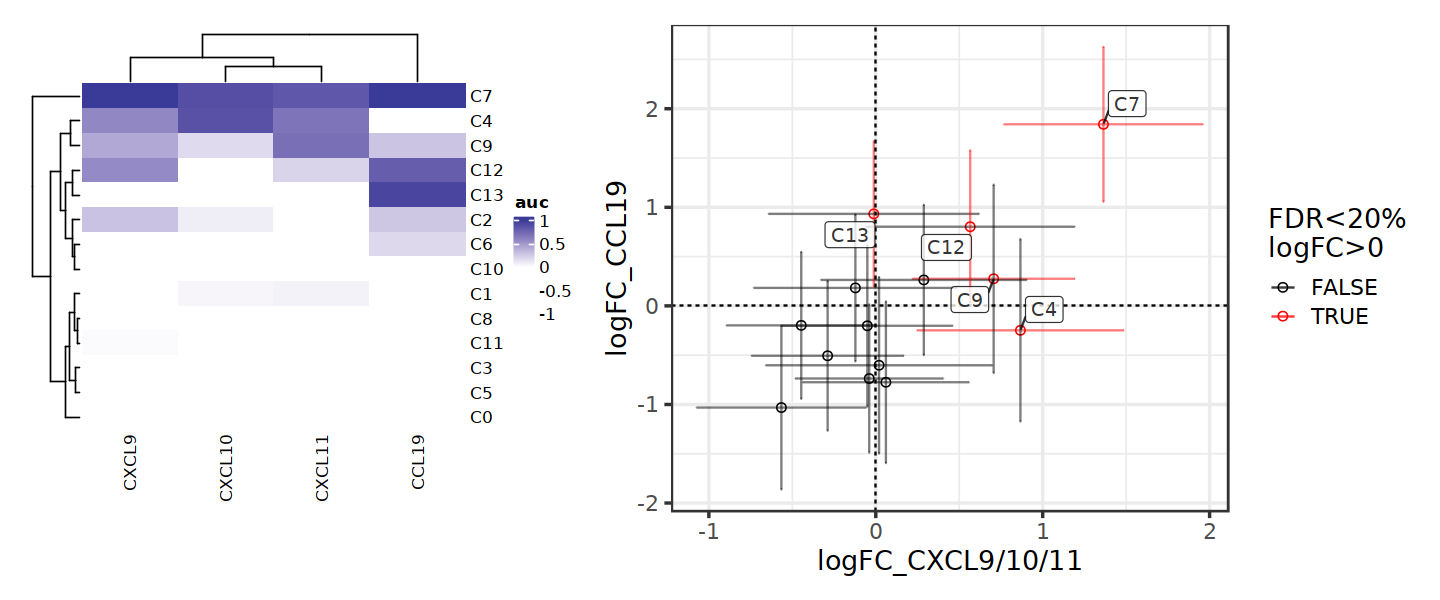

In [254]:
fig.size(5, 12)
plt_heat | plt_stats


## Heatmap

In [130]:
g <- markers %>% subset(auc >= .8) %>% with(unique(feature))
length(g)

X <- markers %>% 
    subset(feature %in% g) %>% 
    subset(group %in% clusters_shared) %>% 
    dplyr::select(group, feature, SCORE = auc) %>% 
    tidyr::spread(group, SCORE) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix()


In [ ]:
fig.size(20, 10)
Heatmap(
    X,
    colorRamp2(c(0, 0.5, 1), c('white', 'white', muted('blue')))
)

In [67]:
# fig.size(6, 14)
# do_markers_heatmap(
#     markers, 
#     # highlights = list(
#     #     'Fibroblast:COL3A1_Fibroblast' = c('COL3A1'),
#     #     'Fibroblast:FN1_Fibroblast' = c('FN1'),
#     #     'Tcell:CD4' = c('CD4'),
#     #     'Tcell:CD8' = c('CD8A'),
#     #     'Tcell:TCF7_CD8' = c('TCF7'),
#     #     'Myeloid:LAMP3_Dendritic' = c('LAMP3'),
#     #     'Tcell:Treg' = c('FOXP3'),
#     #     'Mural' = c('NOTCH3')
#     # ),
#     topn=2, auc_min=0.8, 
#     rank_by='auc', 
#     color_by='auc', 
#     show_negative = FALSE,
#     fontsize_rows = 10
# )
